In [1]:
library(nlme)
library(multcomp)
options(jupyter.plot_mimetypes = "image/png")
library(ggplot2)
library(corrplot)
library(gridExtra)
library(grid)
library(data.table)
library(effects)
library(xtable)

Loading required package: mvtnorm
Loading required package: survival
Loading required package: TH.data
Loading required package: MASS

Attaching package: ‘TH.data’

The following object is masked from ‘package:MASS’:

    geyser



## Load Data

In [2]:
data = read.csv("../Data/Data_Classifications_v6.csv")

data<-data[c('PID','Info.type','Accuracy.50','Significance','Roi.Search',
             'Pattern.type','Classifier.type','Scanner','Smoothing','Coregistration','Pattern.normalization.type','Num_subs')]

factors<-c('Info.type','Significance','Roi.Search',
             'Pattern.type','Classifier.type','Scanner','Smoothing','Coregistration','Pattern.normalization.type','Num_subs')

for (pid in unique(data$PID)){
    #print('--')
    #print(pid)
    #print(nrow(data1[data1$PID==pid,]))
    #print('--')
    data[data$PID==pid,'n_per_study']=nrow(data[data$PID==pid,])
}


# msc

R1 = read.csv(paste("X_region1_before_clustering.csv"))
R2 = read.csv(paste("X_region1_after_clustering.csv"))
R3 = read.csv(paste("X_region1_after_clustering_lr.csv"))
R4 = read.csv(paste("X_region1_after_clustering2.csv"))


R1names = colnames(R1)
R2names = colnames(R2)
R3names = colnames(R3)
R4names = colnames(R4)

i=1
for (name in R3names){
    R3names[i]<-paste(sep='','R3',name)
    i=i+1
}
R3names
colnames(R3)<-R3names
head(R3)

i=1
for (name in R4names){
    R4names[i]<-paste(sep='','R4',name)
    i=i+1
}
R4names
colnames(R4)<-R4names
head(R4)

[1] "R3Precentral"         "R3Frontal_Mid"        "R3Frontal_Mid_Orb"   
 [4] "R3Frontal_Inf_Orb"    "R3Frontal_Inf_Oper"   "R3Frontal_Inf_Tri"   
 [7] "R3Supp_Motor_Area"    "R3Cingulum_Mid"       "R3Cingulum_Ant"      
[10] "R3Frontal_Sup"        "R3Frontal_Sup_Medial" "R3Insula"

R3Precentral R3Frontal_Mid R3Frontal_Mid_Orb R3Frontal_Inf_Orb
1            0             0                 0                 0
2            0             0                 0                 0
3            0             0                 0                 0
4            0             0                 0                 0
5            0             0                 0                 0
6            0             0                 0                 0
  R3Frontal_Inf_Oper R3Frontal_Inf_Tri R3Supp_Motor_Area R3Cingulum_Mid
1                  0                 1                 0              0
2                  0                 0                 0              0
3                  0                 1                 0              0
4                  0                 0                 0              0
5                  0                 1                 0              0
6                  0                 1                 0              0
  R3Cingulum_Ant R3Frontal_Sup R3Frontal_Sup_Medial R3Insula
1              0             0                    0        0
2              0             0                    0        1
3              0             0                    0        0
4              0             0                    0        1
5              0             0                    0        0
6              0             0                    0        0

[1] "R4Frontal_Sup" "R4Frontal_Mid" "R4Frontal_Inf" "R4Insula"     
[5] "R4Motor"       "R4Cingulum"

R4Frontal_Sup R4Frontal_Mid R4Frontal_Inf R4Insula R4Motor R4Cingulum
1             0             0             1        0       0          0
2             0             0             0        1       0          0
3             0             0             1        0       0          0
4             0             0             0        1       0          0
5             0             0             1        0       0          0
6             0             0             1        0       0          0

In [172]:
unique(data$Pattern.normalization.type)

[1] None                  Normalized Spatially  Normalized Temporally
Levels: None Normalized Spatially Normalized Temporally

In [3]:
data = cbind(data,R3,R4) # will bind with other region names too 


# mscl fixed 
data<-data[!data$Classifier.type=='neural-net',] # no observations but still has a level
data[data$Scanner=='4T','Scanner']='3T' # only one observatoin with 3T

data$PID<-as.factor(data$PID)
data$Info.type<-as.factor(data$Info.type)
data$Smoothing<-as.factor(data$Smoothing)
data$Roi.Search<-as.factor(data$Roi.Search)
data$Classifier.type<-as.factor(data$Classifier.type)
data$Coregistration<-as.factor(data$Coregistration)
data$Pattern.type<-as.factor(data$Pattern.type)

#data[data$Pattern.normalization.type=='Normalized Spatially']

data$Pattern.normalization.type<-as.factor(data$Pattern.normalization.type)

data<-droplevels(data)

data_50<-subset(data,!is.na(Accuracy.50))

data_50_non<-subset(data,!is.na(Accuracy.50)& Significance==0)

data_50_sig<-subset(data,!is.na(Accuracy.50) & Significance==1)
head(data_50_sig)
nrow(data_50_sig)


# make unique
keys <- colnames(data_50_sig)[!grepl('Accuracy.50',colnames(data_50_sig))] # grab everything but accuracy
X <- as.data.table(data_50_sig)
data_50_sig_unique<- X[,list(Accuracy.50.mean= mean(Accuracy.50)),keys] # average the non-unique
data_50_sig_unique$Accuracy.50<-data_50_sig_unique$Accuracy.50.mean
data_50_sig_unique<-data.frame(data_50_sig_unique)

keys <- colnames(data_50)[!grepl('Accuracy.50',colnames(data_50))] # grab everything but accuracy
X <- as.data.table(data_50)
data_50_unique<- X[,list(Accuracy.50.mean= mean(Accuracy.50)),keys] # average the non-unique
data_50_unique$Accuracy.50<-data_50_unique$Accuracy.50.mean
data_50_unique<-data.frame(data_50_unique)



nrow(data_50_sig_unique)
nrow(data_50_unique)

PID  Info.type Accuracy.50 Significance Roi.Search
8    1 Perceptual       0.528            1        ROI
9    1       Rule       0.535            1        ROI
10   1       Rule       0.541            1        ROI
11   1       Rule       0.543            1        ROI
12   1       Rule       0.593            1        ROI
16   2       Rule       0.640            1        ROI
                    Pattern.type Classifier.type Scanner Smoothing
8   Multi-Trial Multi-Time Point         svm-lin      3T  unsmooth
9   Multi-Trial Multi-Time Point         svm-lin      3T  unsmooth
10  Multi-Trial Multi-Time Point         svm-lin      3T  unsmooth
11  Multi-Trial Multi-Time Point         svm-lin      3T  unsmooth
12  Multi-Trial Multi-Time Point         svm-lin      3T  unsmooth
16 Single Trial Multi-Time Point             LDA      3T  unsmooth
   Coregistration Pattern.normalization.type Num_subs n_per_study R3Precentral
8    Native Space                       None       17          12            0
9    Native Space                       None       17          12            0
10   Native Space                       None       17          12            0
11   Native Space                       None       17          12            0
12   Native Space                       None       17          12            0
16   Native Space                       None        6           4            1
   R3Frontal_Mid R3Frontal_Mid_Orb R3Frontal_Inf_Orb R3Frontal_Inf_Oper
8              0                 0                 0                  0
9              0                 0                 0                  0
10             0                 0                 0                  0
11             0                 0                 0                  0
12             0                 0                 0                  0
16             0                 0                 0                  0
   R3Frontal_Inf_Tri R3Supp_Motor_Area R3Cingulum_Mid R3Cingulum_Ant
8                  0                 0              0              0
9                  0                 0              0              0
10                 1                 0              0              0
11                 0                 0              0              0
12                 1                 0              0              0
16                 0                 0              0              0
   R3Frontal_Sup R3Frontal_Sup_Medial R3Insula R4Frontal_Sup R4Frontal_Mid
8              0                    0        1             0             0
9              0                    0        1             0             0
10             0                    0        0             0             0
11             0                    0        1             0             0
12             0                    0        0             0             0
16             0                    0        0             0             0
   R4Frontal_Inf R4Insula R4Motor R4Cingulum
8              0        1       0          0
9              0        1       0          0
10             1        0       0          0
11             0        1       0          0
12             1        0       0          0
16             0        0       1          0

[1] 385

[1] 148

[1] 245

## Basic Plots 

### Factor Plots 

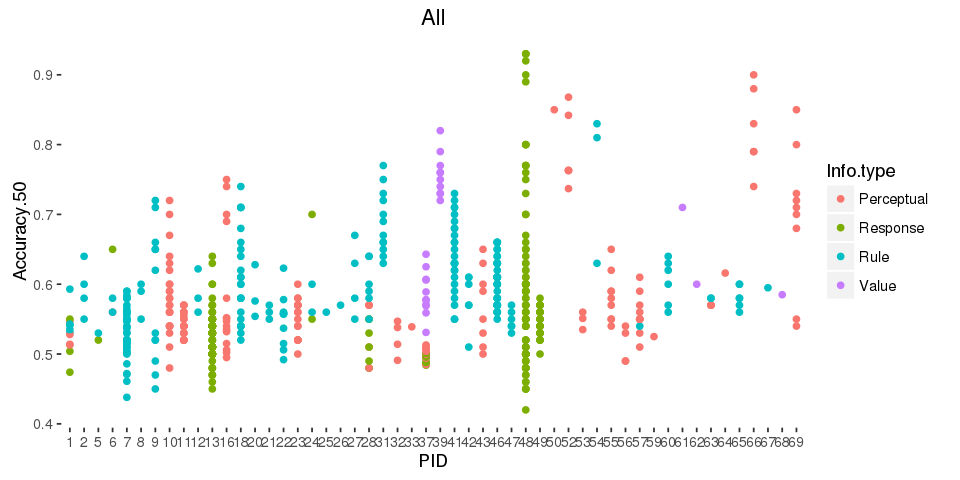

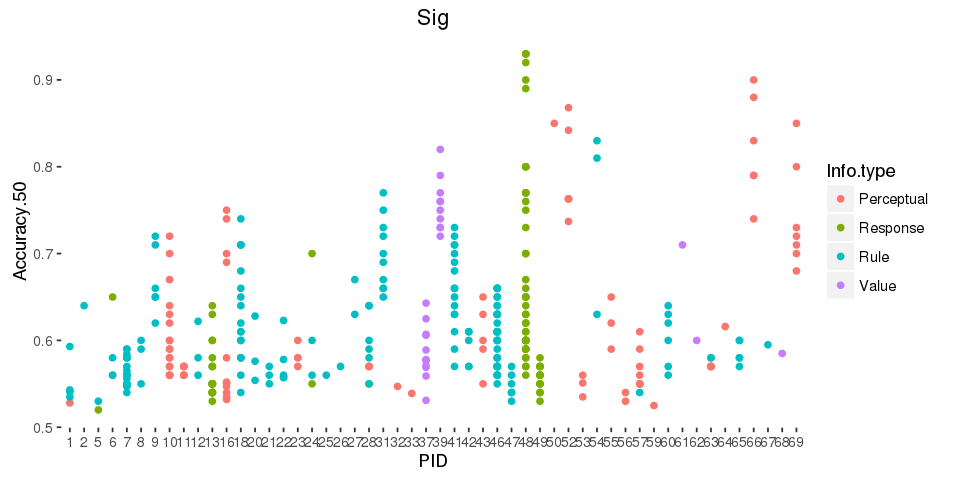

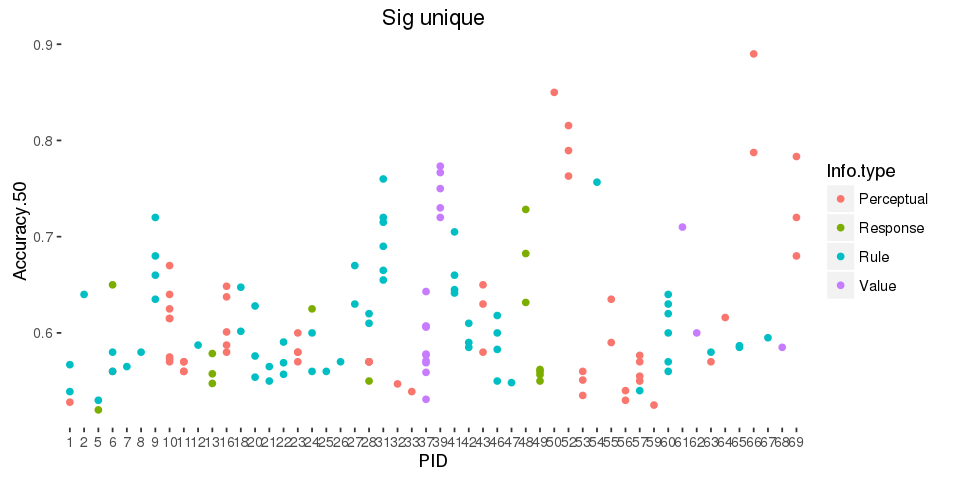

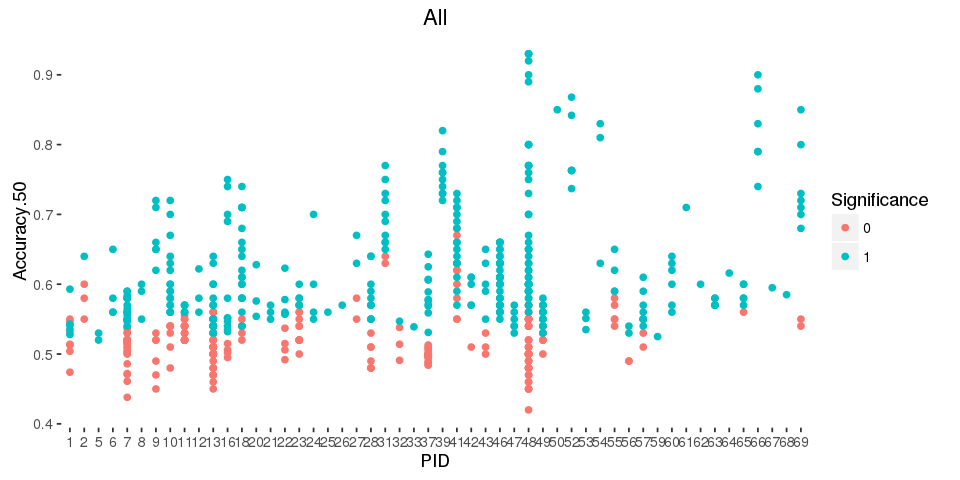

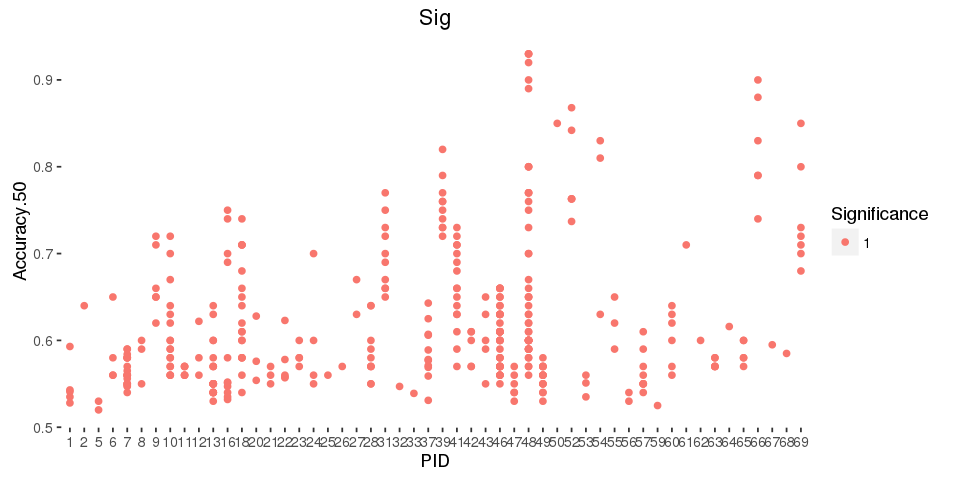

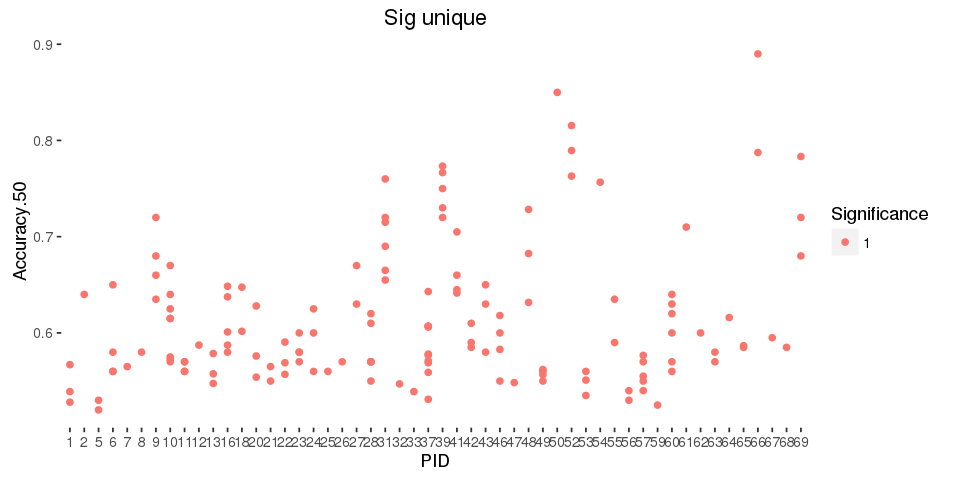

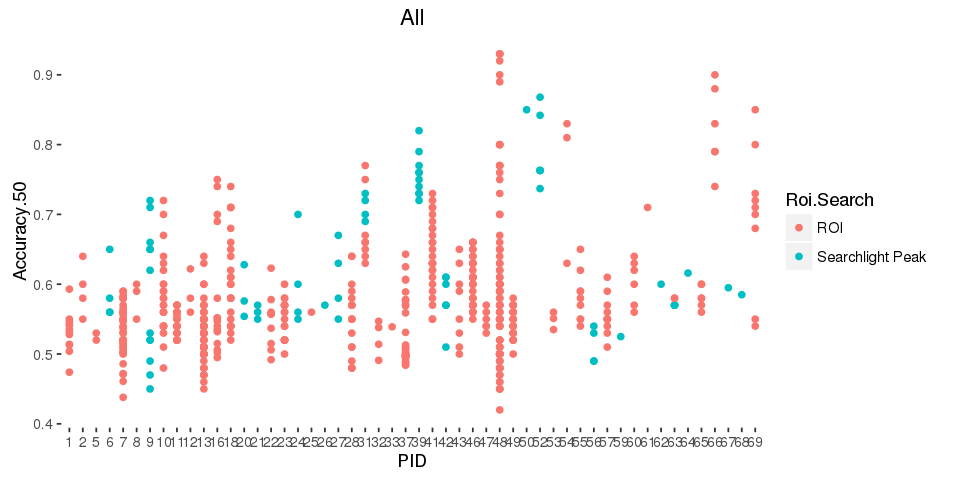

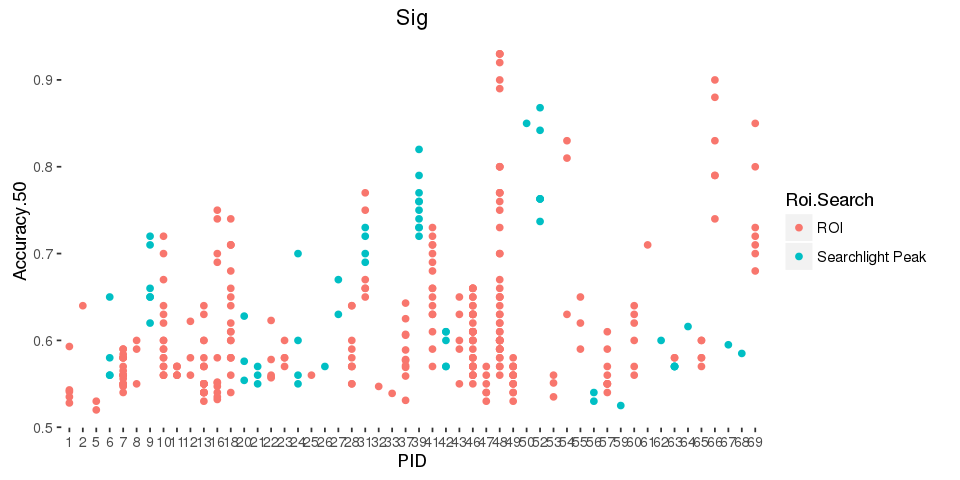

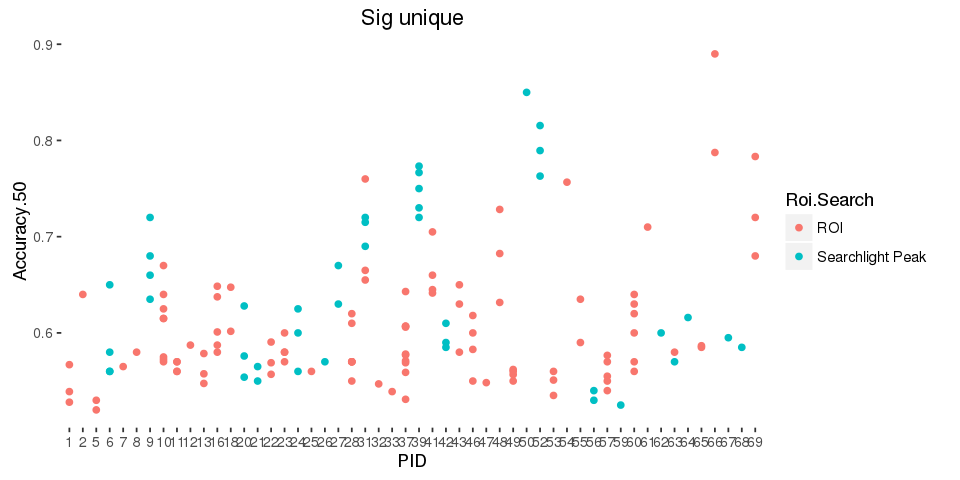

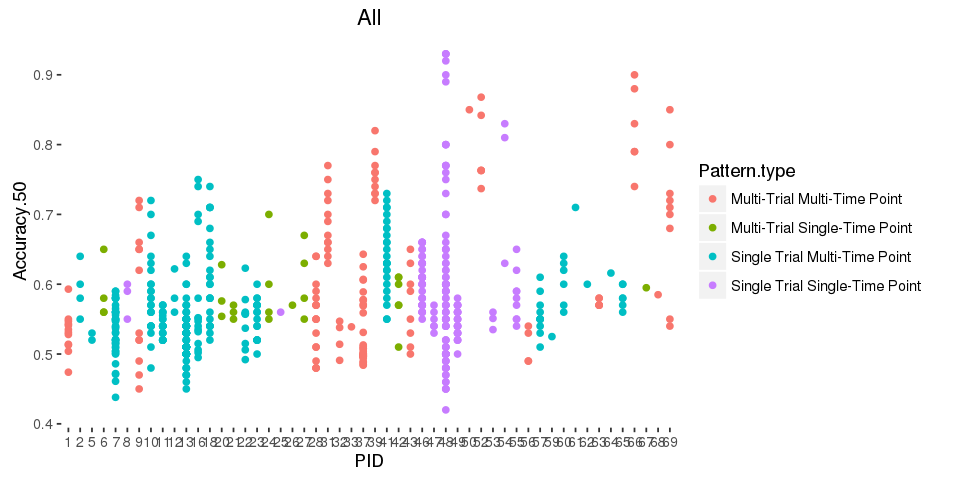

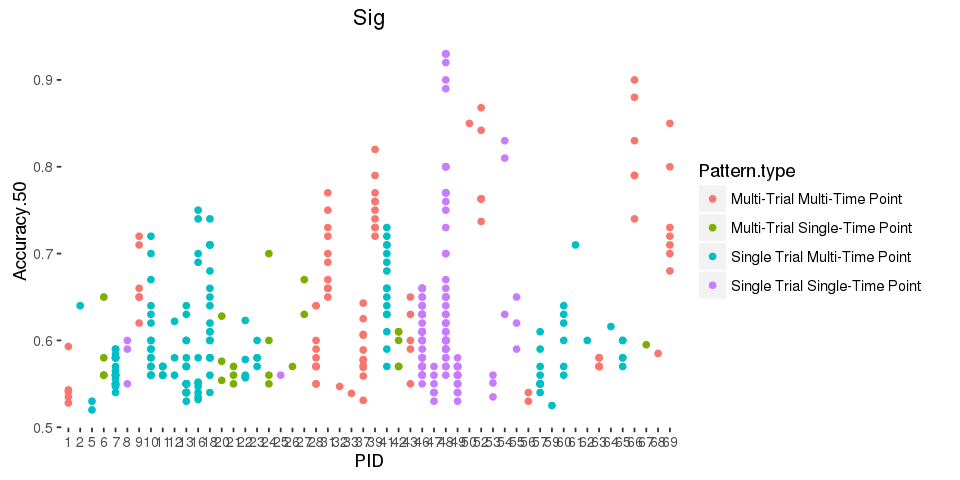

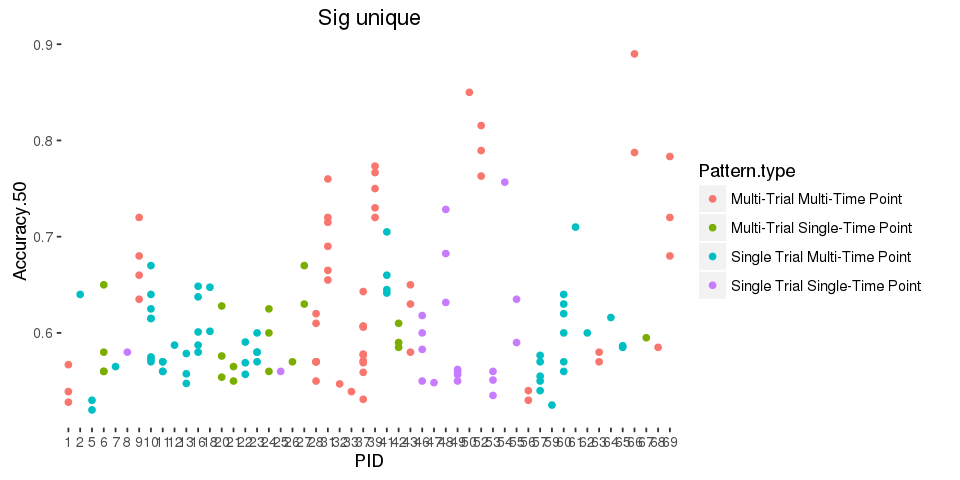

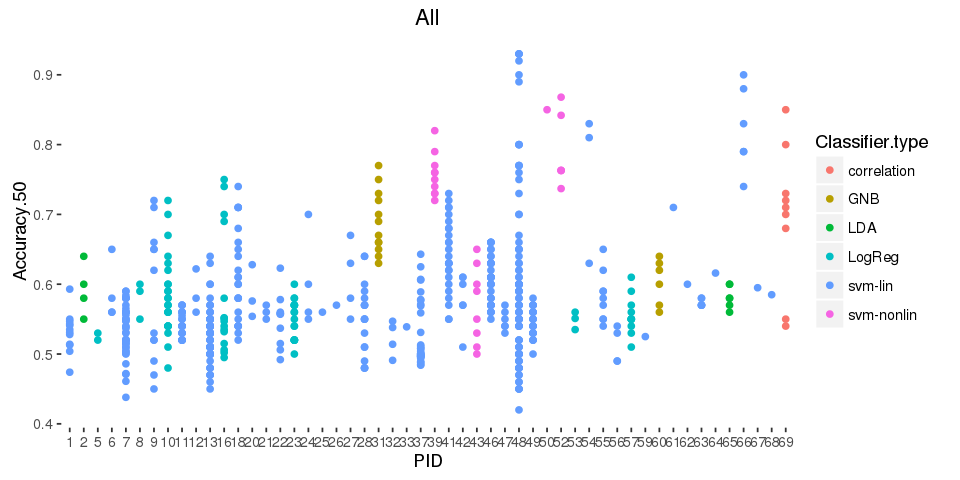

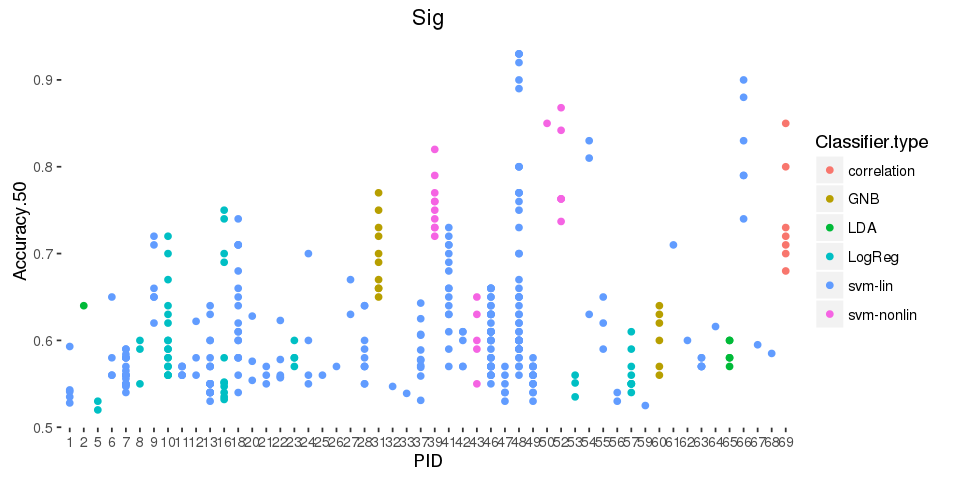

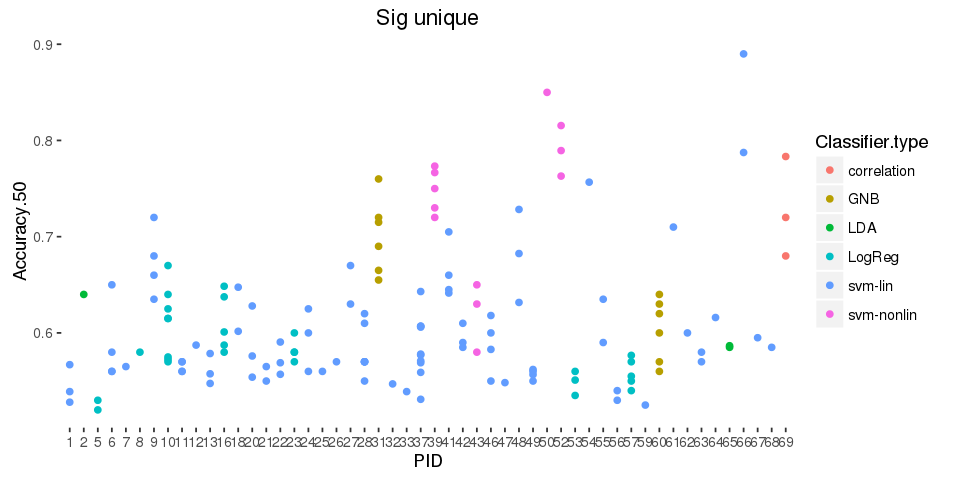

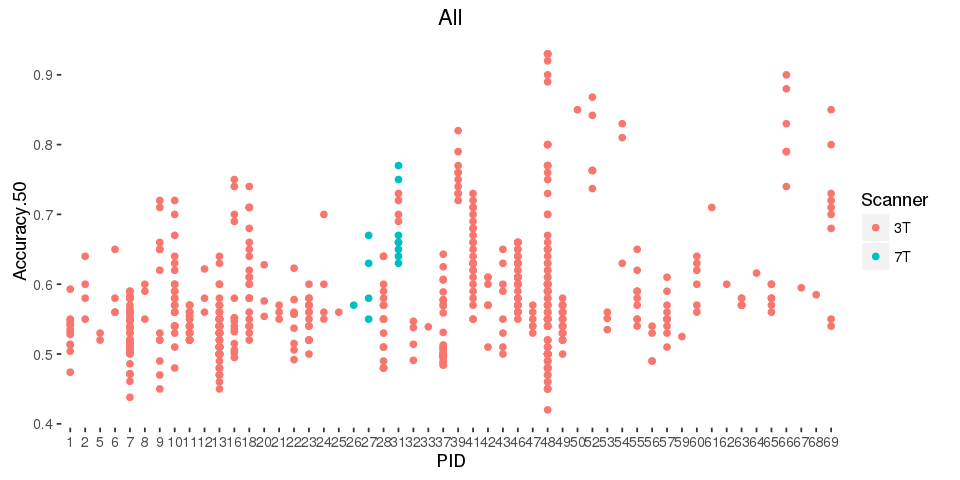

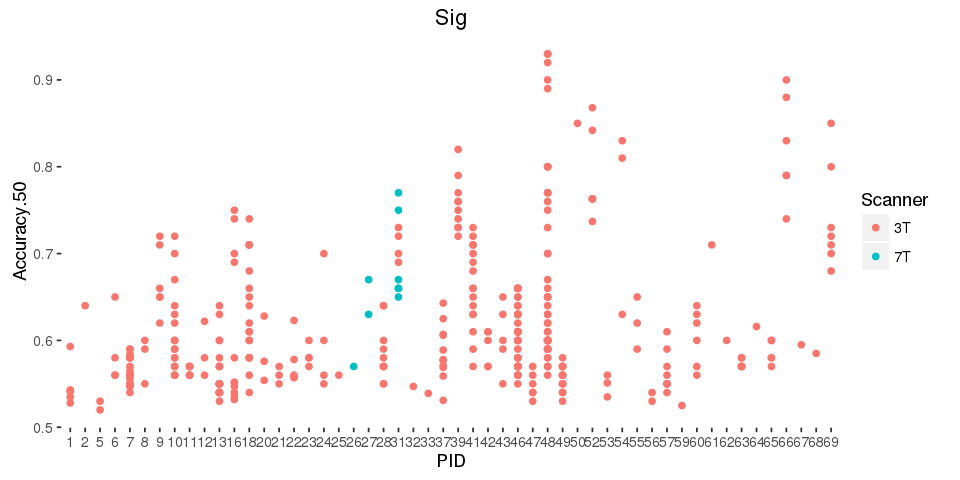

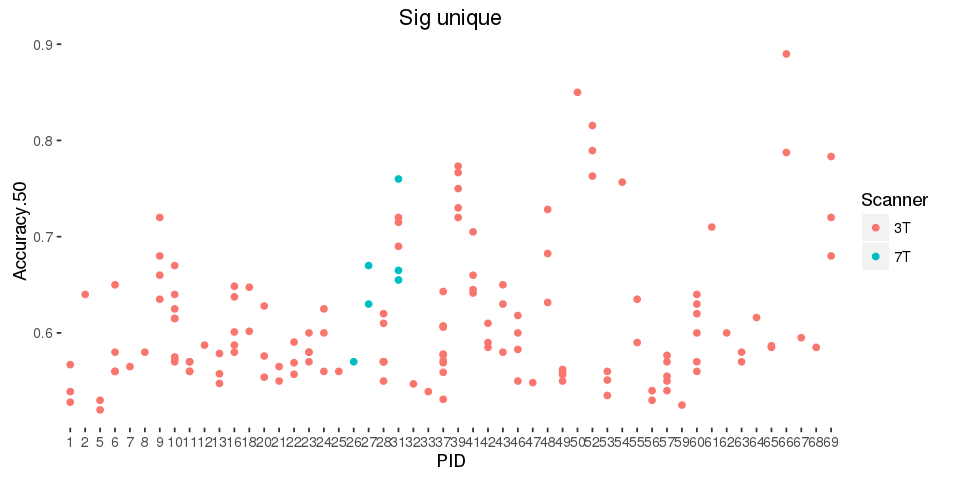

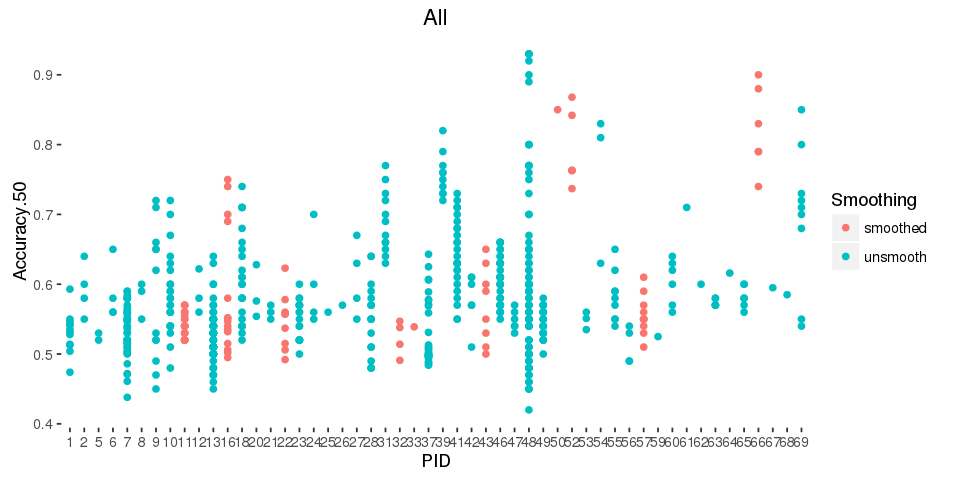

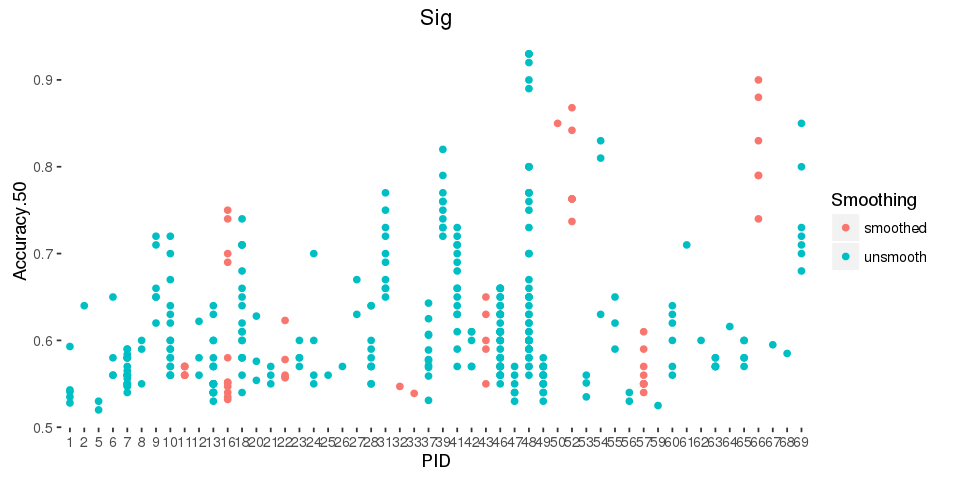

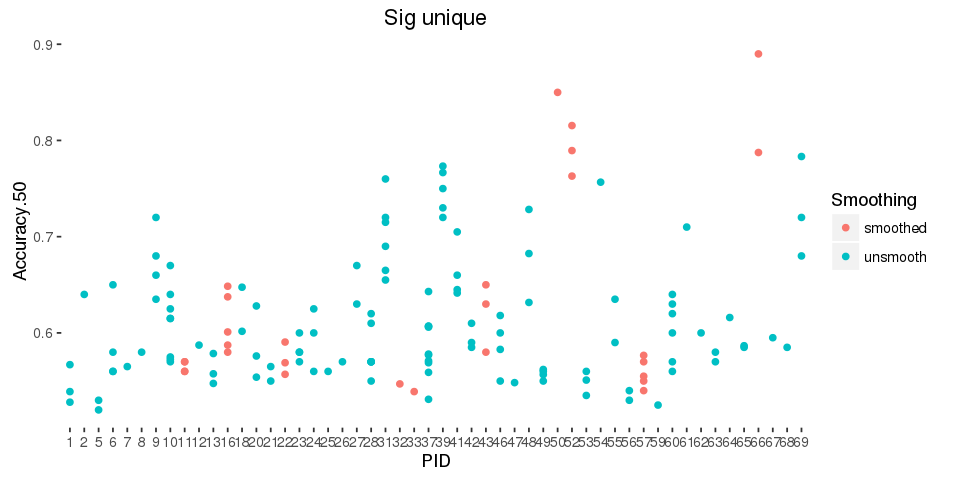

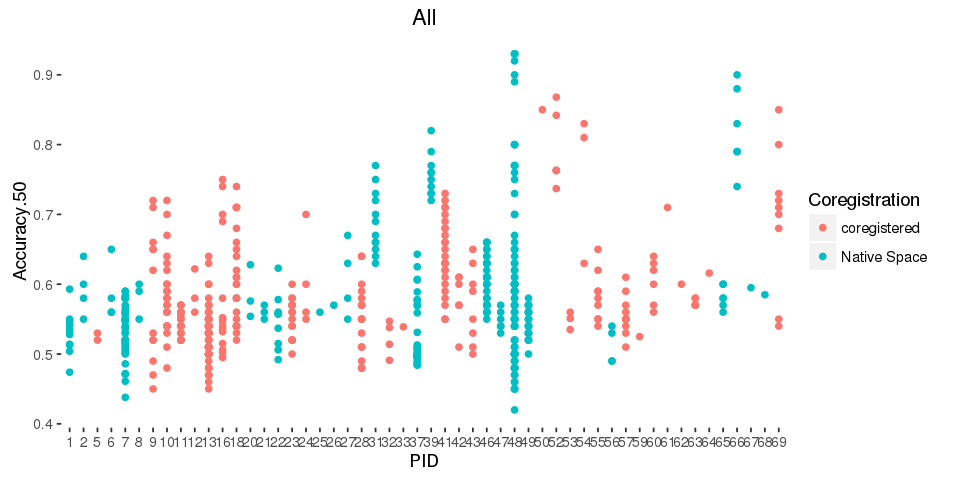

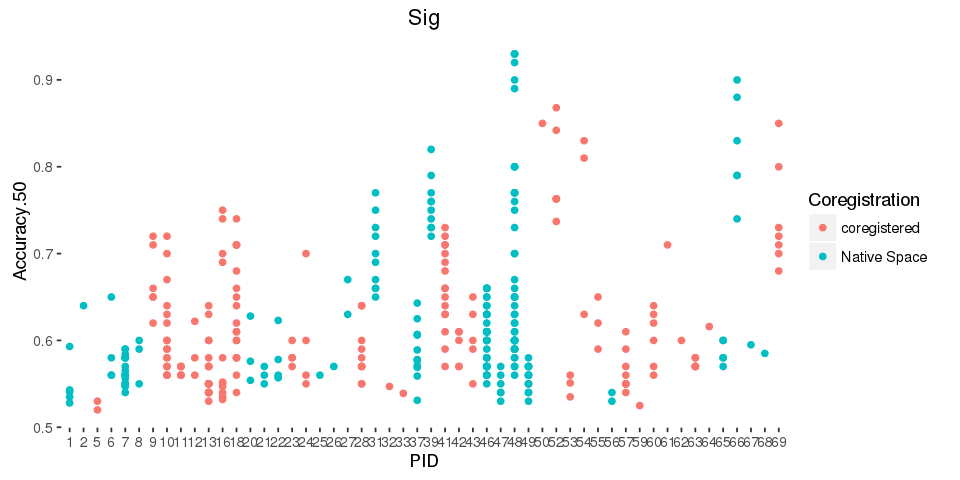

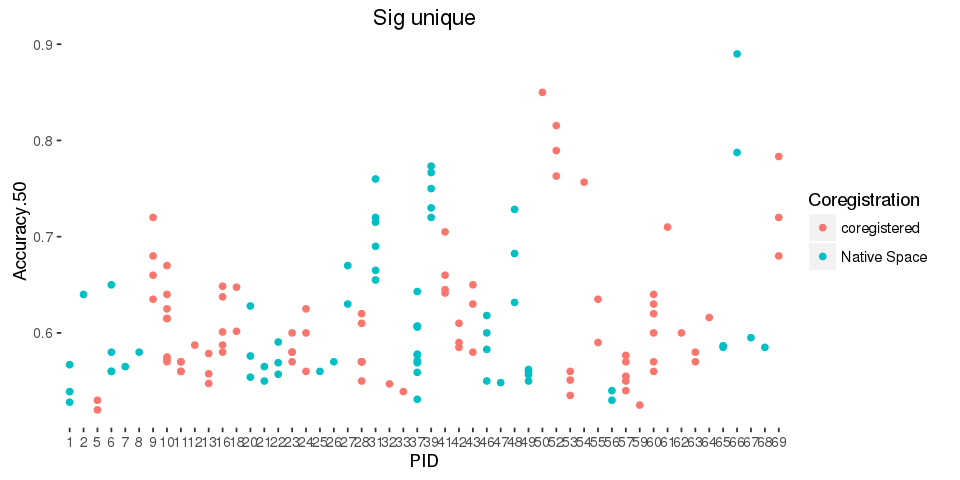

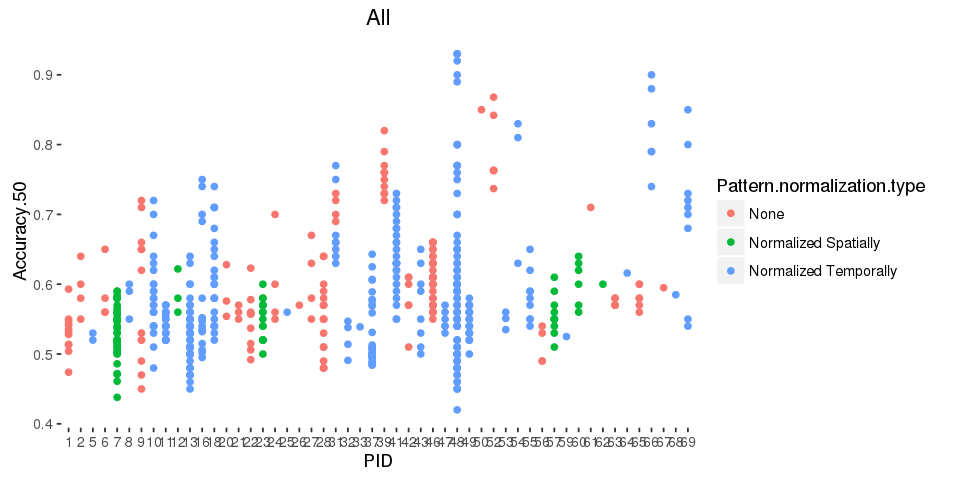

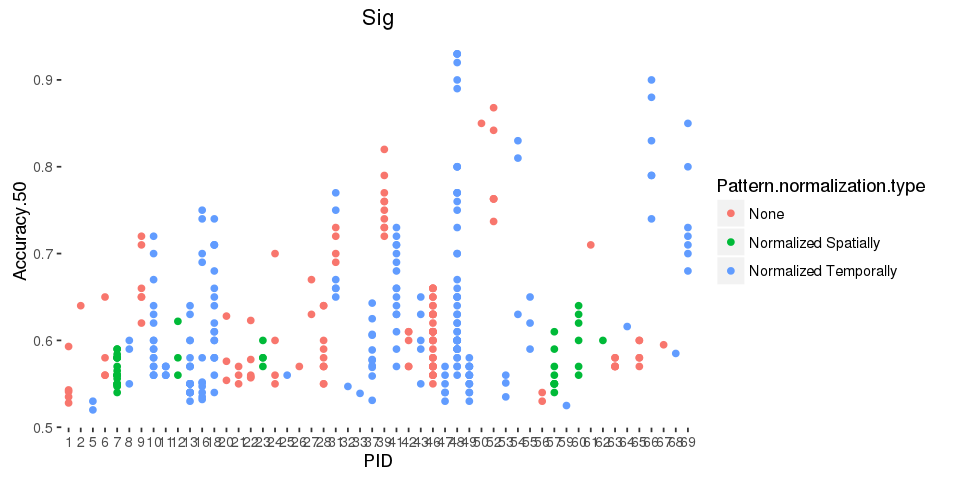

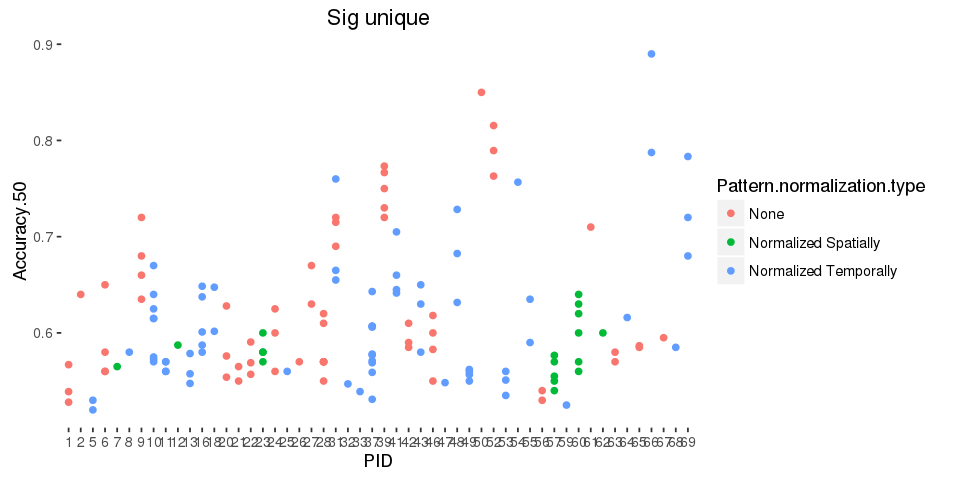

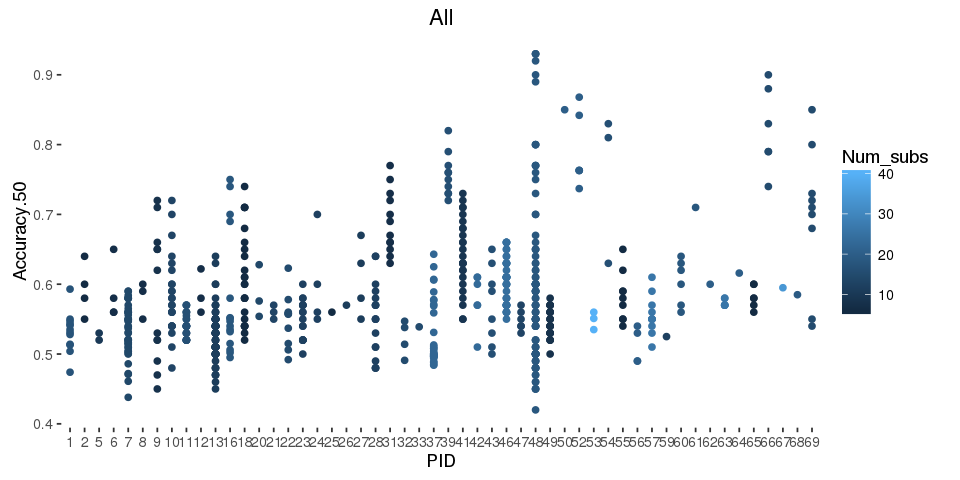

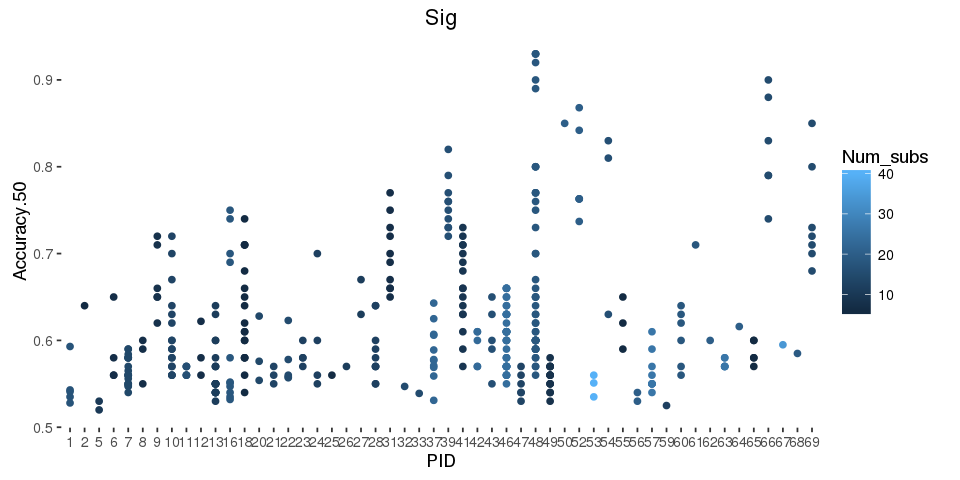

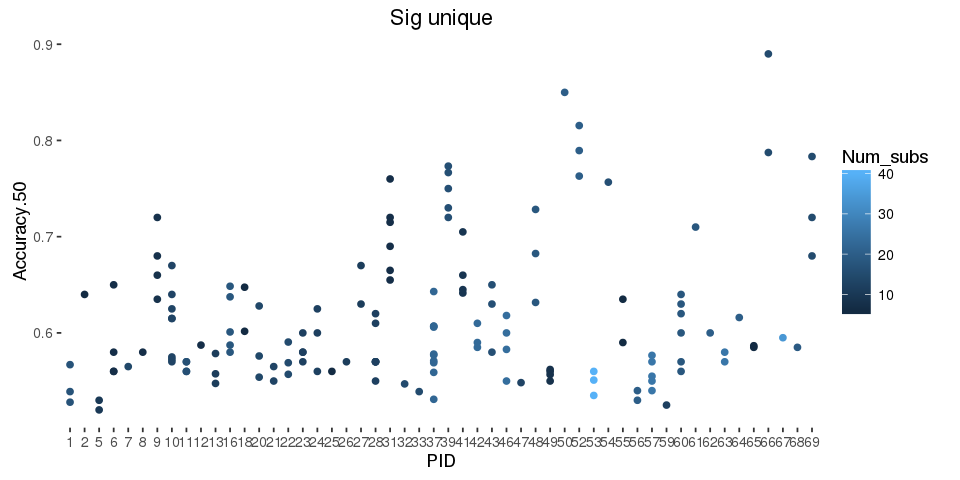

In [237]:
for (factor in factors){
    options(repr.plot.width=8, repr.plot.height=4)
    p1<-ggplot(aes_string(y='Accuracy.50', x = 'PID',color=factor), data = data_50_sig_unique) +geom_point()+ggtitle('Sig unique')+theme(panel.background=element_blank())
    p2<-ggplot(aes_string(y='Accuracy.50', x = 'PID',color=factor), data = data_50_sig) +geom_point()+ggtitle('Sig')+theme(panel.background=element_blank())
    p3<-ggplot(aes_string(y='Accuracy.50', x = 'PID',color=factor), data = data_50) +geom_point()+ggtitle('All')+theme(panel.background=element_blank())
    #p4<-ggplot(aes_string(y='Accuracy.50', x = 'PID',color=factor), data = data_50_unique) +geom_point()+ggtitle('Sig')
    print(p3)
    print(p2)
    print(p1)
    #+theme(panel.background=element_blank())

    #options(repr.plot.width=8, repr.plot.height=4)
    #ggplot(aes(y = Accuracy.50, x = PID,color=Info.type), data = data_50_unique) +geom_point()+ggtitle('All')
    
}


In [238]:
factors

[1] "Info.type"                  "Significance"              
 [3] "Roi.Search"                 "Pattern.type"              
 [5] "Classifier.type"            "Scanner"                   
 [7] "Smoothing"                  "Coregistration"            
 [9] "Pattern.normalization.type" "Num_subs"

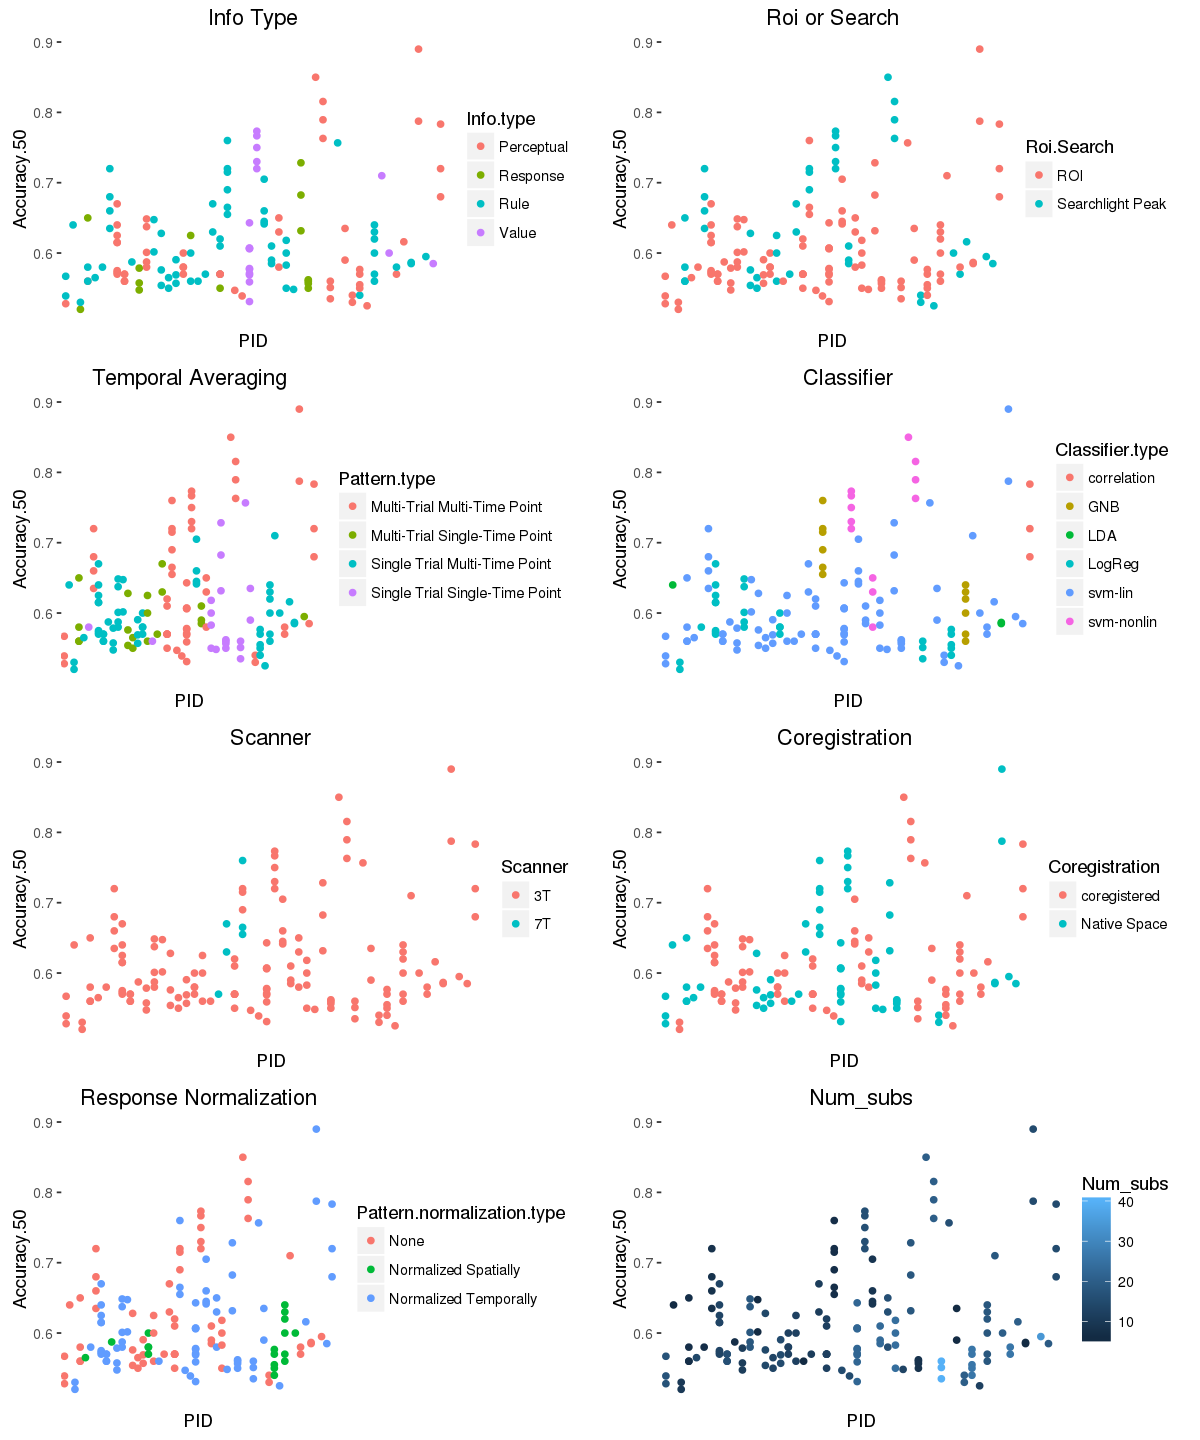

In [264]:
options(repr.plot.width=10, repr.plot.height=12)
p1<-ggplot(aes_string(y='Accuracy.50', x = 'PID',color='Info.type'), data = data_50_sig_unique) +ggtitle('Info Type')+geom_point()+theme(panel.background=element_blank(),axis.ticks.x=element_blank() ,axis.text.x=element_blank())
p2<-ggplot(aes_string(y='Accuracy.50', x = 'PID',color='Roi.Search'), data = data_50_sig_unique) +ggtitle('Roi or Search')+geom_point()+theme(panel.background=element_blank(),axis.ticks.x=element_blank(), axis.text.x=element_blank())
p3<-ggplot(aes_string(y='Accuracy.50', x = 'PID',color='Pattern.type'), data = data_50_sig_unique) +ggtitle('Temporal Averaging')+geom_point()+theme(panel.background=element_blank(),axis.ticks.x=element_blank(), axis.text.x=element_blank())
p4<-ggplot(aes_string(y='Accuracy.50', x = 'PID',color='Classifier.type'), data = data_50_sig_unique) +ggtitle('Classifier')+geom_point()+theme(panel.background=element_blank(),axis.ticks.x=element_blank(), axis.text.x=element_blank())

p5<-ggplot(aes_string(y='Accuracy.50', x = 'PID',color='Scanner'), data = data_50_sig_unique)+ggtitle('Scanner') +geom_point()+theme(panel.background=element_blank(),axis.ticks.x=element_blank(), axis.text.x=element_blank())
p6<-ggplot(aes_string(y='Accuracy.50', x = 'PID',color='Coregistration'), data = data_50_sig_unique)+ggtitle('Coregistration') +geom_point()+theme(panel.background=element_blank(),axis.ticks.x=element_blank(), axis.text.x=element_blank())
p7<-ggplot(aes_string(y='Accuracy.50', x = 'PID',color='Pattern.normalization.type'), data = data_50_sig_unique) +ggtitle('Response Normalization')+geom_point()+theme(panel.background=element_blank(),axis.ticks.x=element_blank(), axis.text.x=element_blank())

p8<-ggplot(aes_string(y='Accuracy.50', x = 'PID',color='Num_subs'), data = data_50_sig_unique) +ggtitle('Num_subs')+geom_point()+theme(panel.background=element_blank(),axis.ticks.x=element_blank(), axis.text.x=element_blank())



lay <- rbind(c(1,2),
             c(3,4),
            c(5,6),
            c(7,8))


grid.arrange(p1,p2,p3,p4,p5,p6,p7,p8,layout_matrix = lay)

### Region Plots

In [ ]:
d

In [ ]:
R3names

In [140]:
plot_list <- list()
i<-1
for (pid in unique(data_50_sig_unique$PID)){
    

    # make two arrays
    # accuracy per study
    # associated region per study
    
    # all duplicates are in here (e.g. accuracy assigned to 2 regions)
    d<-data_50_sig_unique[data_50_sig_unique[,'PID']==pid,] # note which region dataset this is
    accuracy = c()
    regions = c()
    rownamess=c()
    for (region in R3names){  # note region name here 
        acc = d[d[,region]==1,'Accuracy.50']
        accuracy = append(accuracy,acc)
        rownamess = append(rownamess,rownames(d[d[,region]==1,]))
        regions = append(regions,rep(region,length(acc)))
    }
    
    # data frame 
    # accuracy , region, rownames
    #  ...,     ...,   ... 
   df = data.frame(accuracy,regions,rownamess)

    # plot 
    p<-ggplot(aes(y = accuracy, x = regions,label=rownamess), data = df) +geom_text()+ggtitle(pid)
    p<-p+ theme(axis.text.x = element_text(angle = 90, hjust = 1))
    plot_list[[i]] = p
    i<-i+1
    
}

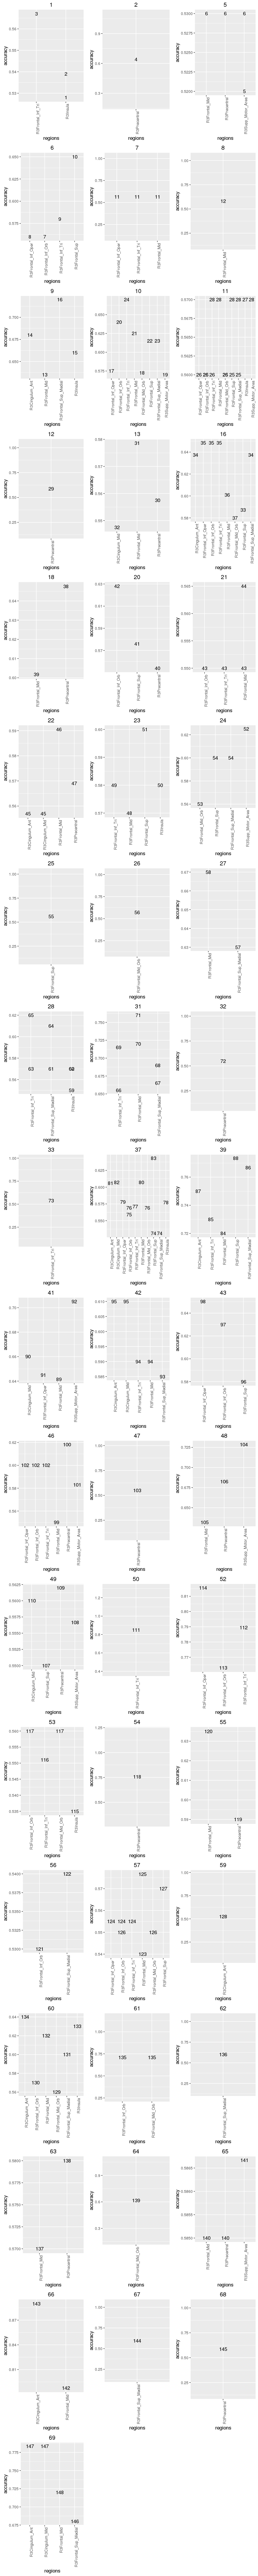

In [141]:
options(repr.plot.width=8, repr.plot.height=80)
do.call(grid.arrange,c(plot_list, ncol=3))

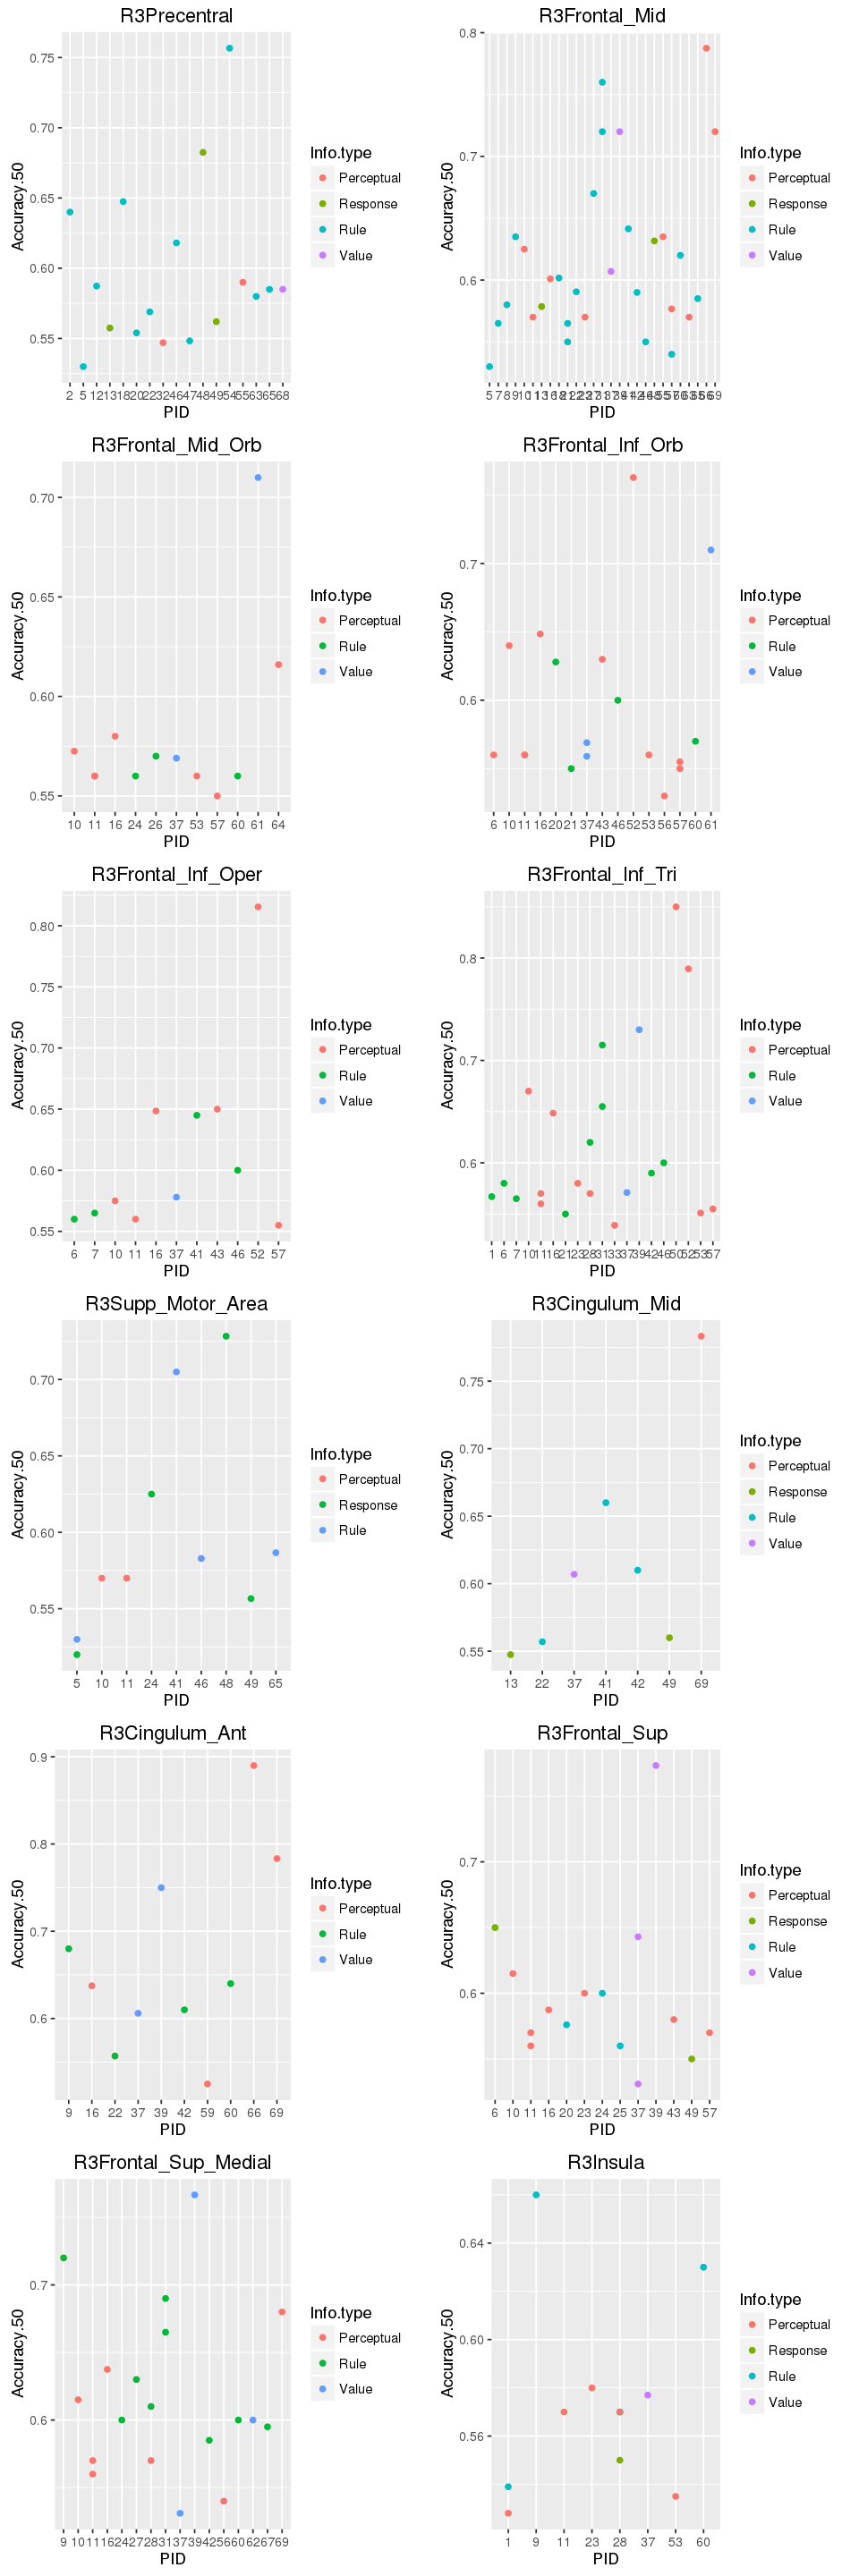

In [154]:
plot_list <- list()
i<-1
options(repr.plot.width=8, repr.plot.height=24)
for (region in R3names){ #
    d<-data_50_sig_unique[data_50_sig_unique[,region]==1,]
    p<-ggplot(aes(y = Accuracy.50, x = PID,color=Info.type), data = d) +geom_point()+ggtitle(region)
    #p<-ggplot(aes(y = Accuracy.50, x = PID), data = d) +geom_point()+ggtitle(region)
    plot_list[[i]] = p
    i<-i+1
    
}

do.call(grid.arrange,c(plot_list, ncol=2))
#grid.arrange(plot_list,ncol=3)

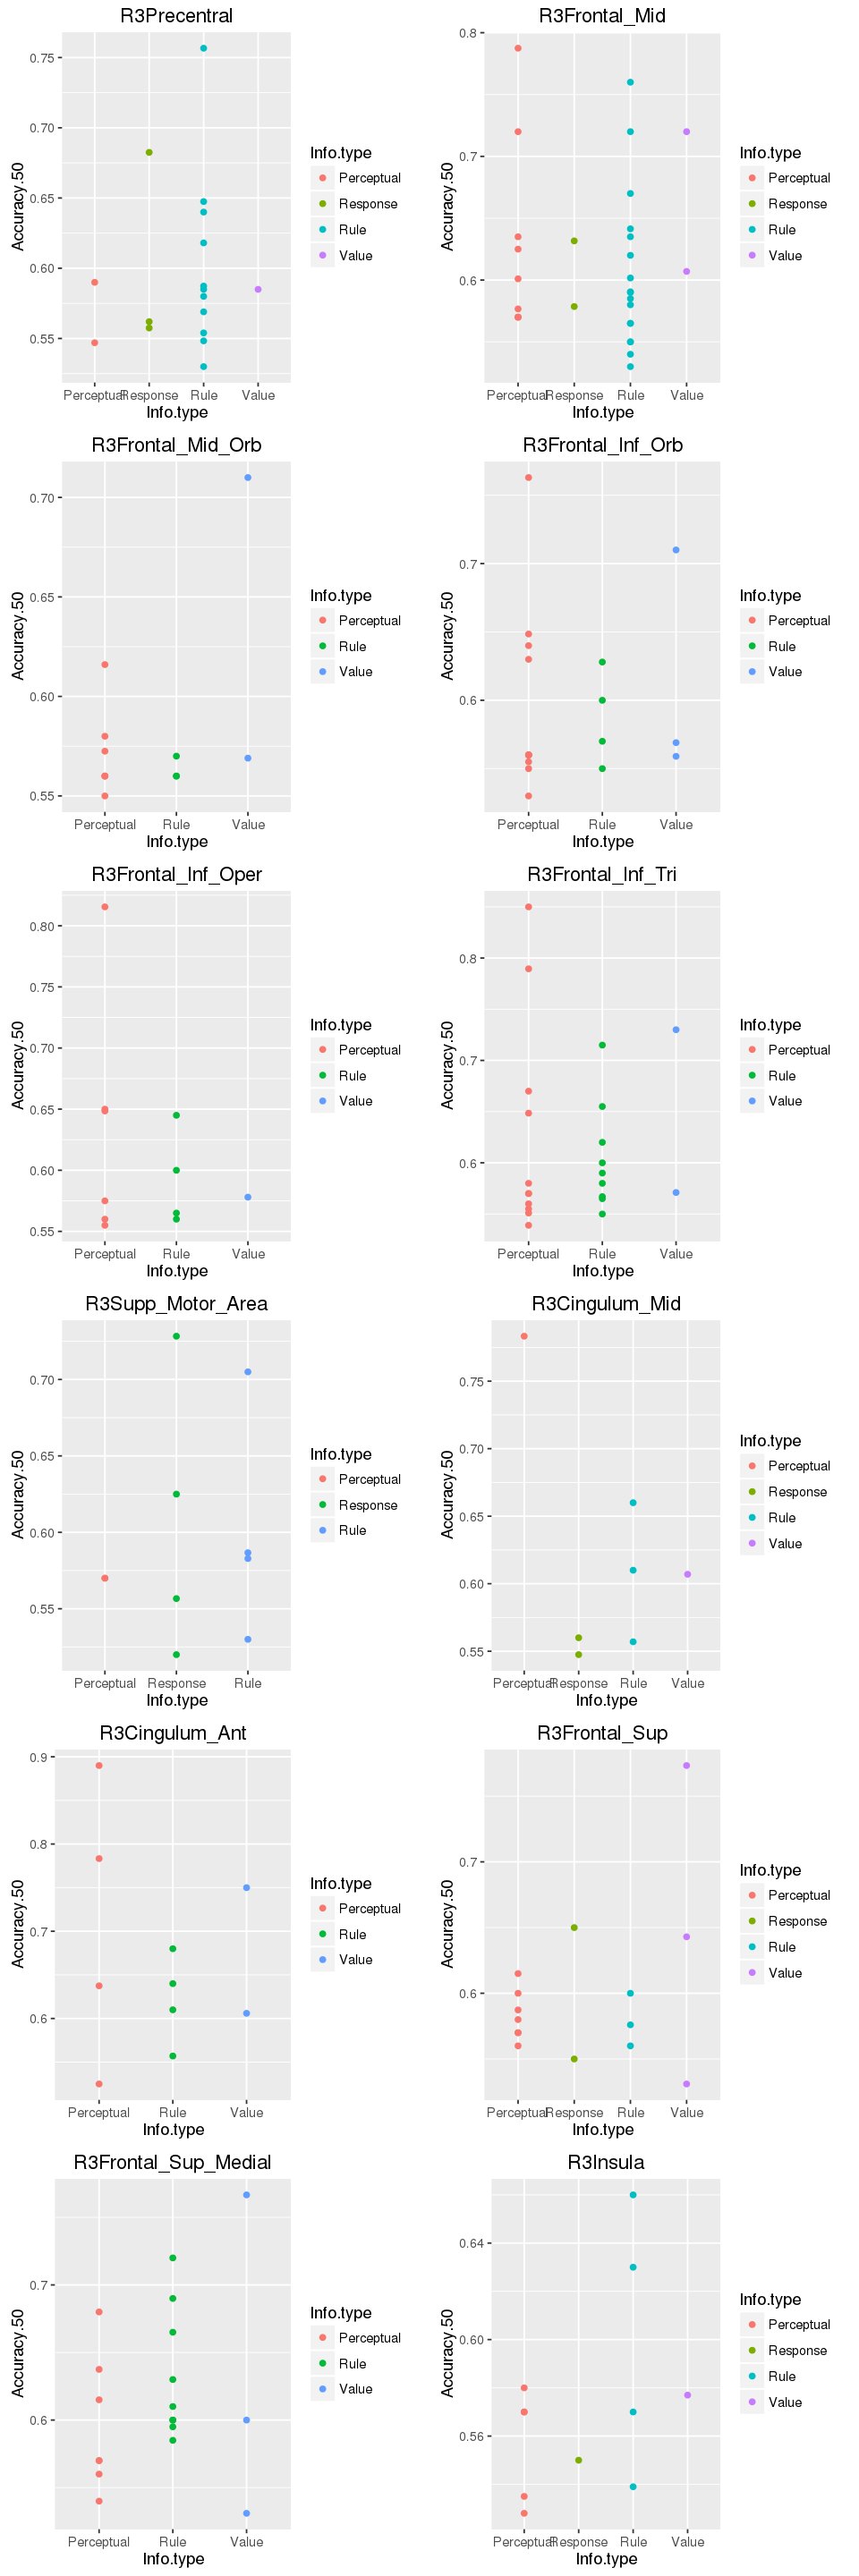

In [191]:
plot_list <- list()
i<-1
options(repr.plot.width=8, repr.plot.height=24)
for (region in R3names){ #
    d<-data_50_sig_unique[data_50_sig_unique[,region]==1,]
    p<-ggplot(aes(y = Accuracy.50, text = PID,x=Info.type,color=Info.type), data = d) +geom_point()+ggtitle(region)#+geom_boxplot()
    #p<-ggplot(aes(y = Accuracy.50, x = PID), data = d) +geom_point()+ggtitle(region)
    plot_list[[i]] = p
    i<-i+1
    
}

do.call(grid.arrange,c(plot_list, ncol=2))
#grid.arrange(plot_list,ncol=3)

In [ ]:
#ggplot(aes(y = Accuracy.50, x=Info.type,color=Info.type), data = d) +geom_point()+ggtitle(region)+geom_boxplot()+facet_wrap()

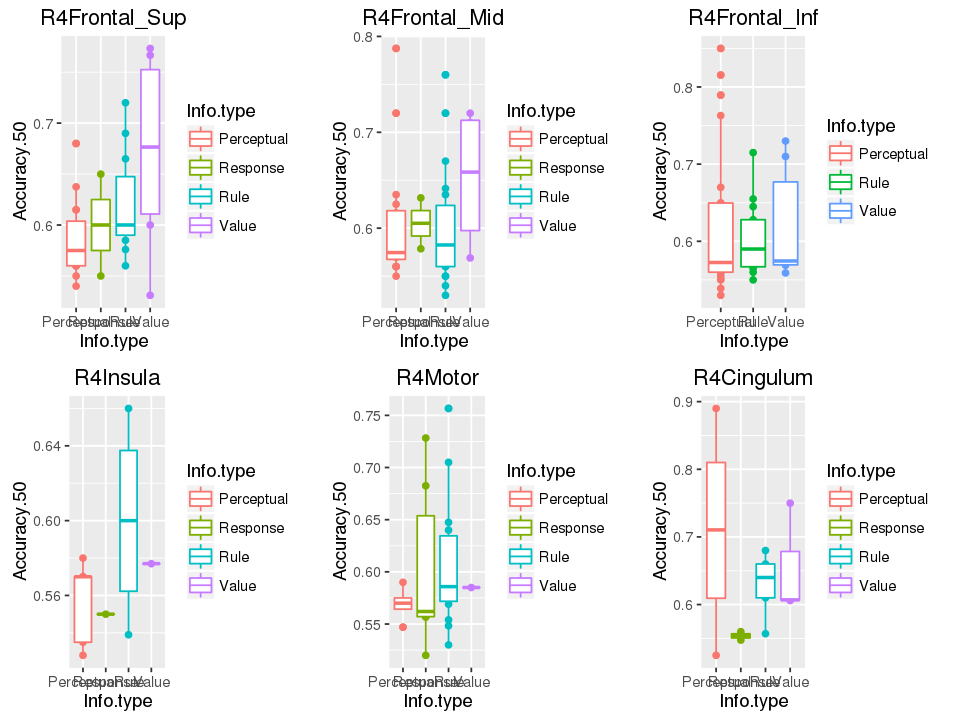

In [189]:
plot_list <- list()
i<-1
options(repr.plot.width=8, repr.plot.height=6)
for (region in R4names){ #
    d<-data_50_sig_unique[data_50_sig_unique[,region]==1,]
    p<-ggplot(aes(y = Accuracy.50, x=Info.type,color=Info.type), data = d) +geom_point()+ggtitle(region)+geom_boxplot()
    #p<-ggplot(aes(y = Accuracy.50, x = PID), data = d) +geom_point()+ggtitle(region)
    plot_list[[i]] = p
    i<-i+1
    
}

do.call(grid.arrange,c(plot_list, ncol=3))
#grid.arrange(plot_list,ncol=3)

In [ ]:
plot_list <- list()
i<-1
options(repr.plot.width=8, repr.plot.height=24)
for (region in colnames(data3)){
    d<-data_r_coll0[data_r_coll0[,region]==1,]
    #ggplot(aes(y = Accuracy.50, x = PID,color=Classifier.type), data = d) +geom_point()
    p<-ggplot(aes(y = Accuracy.50, x = PID), data = d) +geom_point()+ggtitle(region)
    plot_list[[i]] = p
    i<-i+1
    
}

do.call(grid.arrange,c(plot_list, ncol=2))
#grid.arrange(plot_list,ncol=3)

In [ ]:
plot_list <- list()
i<-1
options(repr.plot.width=8, repr.plot.height=24)
for (region in R3names){
    d<-data_50_sig[data_50_sig[,region]==1,]
    p<-ggplot(aes(y = Accuracy.50, x = PID,color=Info.type), data = d) +geom_point()+ggtitle(region)
    #p<-ggplot(aes(y = Accuracy.50, x = PID), data = d) +geom_point()+ggtitle(region)
    plot_list[[i]] = p
    i<-i+1
    
}

do.call(grid.arrange,c(plot_list, ncol=2))
#grid.arrange(plot_list,ncol=3)

In [194]:
#full_modelI<-lme(Accuracy.50~Info.type*(R3Precentral+R3Frontal_Mid+R3Frontal_Mid_Orb+R3Frontal_Inf_Orb+R3Frontal_Inf_Oper+R3Frontal_Inf_Tri+
#                R3Supp_Motor_Area+R3Cingulum_Mid+R3Cingulum_Ant+R3Frontal_Sup+R3Frontal_Sup_Medial+R3Insula),random=~1|PID,data=d,method='REML')
#summary(full_modelI)#$tTable

## Mixed Effects, Sig, Unique, All Factors 

In [217]:
d<-data_50_sig_unique[c('Accuracy.50','PID',factors,R3names)]

full_model<-lme(Accuracy.50~Info.type+Roi.Search+Pattern.type+Classifier.type+Scanner+
                Smoothing+Coregistration+Pattern.normalization.type+Num_subs+
                R3Precentral+R3Frontal_Mid+R3Frontal_Mid_Orb+R3Frontal_Inf_Orb+R3Frontal_Inf_Oper+R3Frontal_Inf_Tri+
                R3Supp_Motor_Area+R3Cingulum_Mid+R3Cingulum_Ant+R3Frontal_Sup+R3Frontal_Sup_Medial+R3Insula,random=~1|PID,data=d,method='REML')
summary(full_model)#$tTable

#anova(full_model,type='marginal')



Linear mixed-effects model fit by REML
 Data: d 
        AIC       BIC   logLik
  -261.0734 -169.9217 163.5367

Random effects:
 Formula: ~1 | PID
        (Intercept)   Residual
StdDev:  0.06571065 0.02982839

Fixed effects: Accuracy.50 ~ Info.type + Roi.Search + Pattern.type + Classifier.type +      Scanner + Smoothing + Coregistration + Pattern.normalization.type +      Num_subs + R3Precentral + R3Frontal_Mid + R3Frontal_Mid_Orb +      R3Frontal_Inf_Orb + R3Frontal_Inf_Oper + R3Frontal_Inf_Tri +      R3Supp_Motor_Area + R3Cingulum_Mid + R3Cingulum_Ant + R3Frontal_Sup +      R3Frontal_Sup_Medial + R3Insula 
                                                     Value  Std.Error DF
(Intercept)                                      0.8085529 0.09009752 79
Info.typeResponse                                0.0230482 0.02022484 79
Info.typeRule                                    0.0118164 0.01437651 79
Info.typeValue                                   0.0567260 0.04165214 38
Roi.SearchSearchlig

In [211]:
full_model_ml<-lme(Accuracy.50~Info.type+Roi.Search+Pattern.type+Classifier.type+Scanner+
                Smoothing+Coregistration+Pattern.normalization.type+Num_subs+
                R3Precentral+R3Frontal_Mid+R3Frontal_Mid_Orb+R3Frontal_Inf_Orb+R3Frontal_Inf_Oper+R3Frontal_Inf_Tri+
                R3Supp_Motor_Area+R3Cingulum_Mid+R3Cingulum_Ant+R3Frontal_Sup+R3Frontal_Sup_Medial+R3Insula,random=~1|PID,data=d,method='ML')

full_model_wo_region<-lme(Accuracy.50~Info.type+Roi.Search+Pattern.type+Classifier.type+Scanner+
                Smoothing+Coregistration+Pattern.normalization.type+Num_subs,random=~1|PID,data=d,method='ML')

full_model_wo_Classifier.type<-update(full_model_ml,.~. -Classifier.type)
full_model_wo_Info.type<-update(full_model_ml,.~. -Info.type)
full_model_wo_Smoothing<-update(full_model_ml,.~. -Smoothing)
full_model_wo_Coregistration<-update(full_model_ml,.~. -Coregistration)
full_model_wo_Pattern.normalization.type<-update(full_model_ml,.~. -Pattern.normalization.type)
full_model_wo_Num_subs<-update(full_model_ml,.~. -Num_subs)
full_model_wo_Scanner<-update(full_model_ml,.~. -Scanner)
full_model_wo_Pattern.type<-update(full_model_ml,.~. -Pattern.type)


a <-anova(full_model_ml,full_model_wo_Classifier.type)
d<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
a <-anova(full_model_ml,full_model_wo_Info.type)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])
a <-anova(full_model_ml,full_model_wo_Smoothing)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])
a <-anova(full_model_ml,full_model_wo_Coregistration)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])
a <-anova(full_model_ml,full_model_wo_Pattern.normalization.type)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])
a <-anova(full_model_ml,full_model_wo_Num_subs)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])
a <-anova(full_model_ml,full_model_wo_Scanner)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])
a <-anova(full_model_ml,full_model_wo_Pattern.type)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])
a <-anova(full_model_ml,full_model_wo_region)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])
d


Model df       AIC       BIC   logLik
full_model_ml                                1 33 -458.9675 -360.0595 262.4837
full_model_wo_Classifier.type                2 28 -455.5655 -371.6435 255.7827
full_model_wo_Info.type                      2 30 -461.2679 -371.3515 260.6339
full_model_wo_Smoothing                      2 32 -458.5718 -362.6610 261.2859
full_model_wo_Coregistration                 2 32 -459.5744 -363.6636 261.7872
full_model_wo_Pattern.normalization.type     2 31 -460.8777 -367.9641 261.4389
full_model_wo_Num_subs                       2 32 -460.5709 -364.6601 262.2855
full_model_wo_Scanner                        2 32 -459.3486 -363.4378 261.6743
full_model_wo_Pattern.type                   2 30 -462.4360 -372.5197 261.2180
full_model_wo_region                         2 21 -468.2331 -405.2916 255.1166
                                            L.Ratio    p.value
full_model_ml                                    NA         NA
full_model_wo_Classifier.type            13.4019988 0.01988918
full_model_wo_Info.type                   3.6996054 0.29578165
full_model_wo_Smoothing                   2.3956500 0.12167316
full_model_wo_Coregistration              1.3931130 0.23788009
full_model_wo_Pattern.normalization.type  2.0897808 0.35173036
full_model_wo_Num_subs                    0.3965751 0.52886334
full_model_wo_Scanner                     1.6189000 0.20324523
full_model_wo_Pattern.type                2.5314639 0.46963169
full_model_wo_region                     14.7343825 0.25628472

In [212]:
#print(xtable(anova(full_model_ml,full_model_less_Classifier.type)),type='latex')


print(xtable(d),type="latex")
print(xtable(summary(full_model)$tTable),type="latex")

% latex table generated in R 3.2.2 by xtable 1.8-0 package
% Fri Aug  5 02:56:52 2016
\begin{table}[ht]
\centering
\begin{tabular}{rrrrrrrr}
  \hline
 & Model & df & AIC & BIC & logLik & L.Ratio & p.value \\ 
  \hline
full\_model\_ml &   1 & 33.00 & -458.97 & -360.06 & 262.48 &  &  \\ 
  full\_model\_wo\_Classifier.type &   2 & 28.00 & -455.57 & -371.64 & 255.78 & 13.40 & 0.02 \\ 
  full\_model\_wo\_Info.type &   2 & 30.00 & -461.27 & -371.35 & 260.63 & 3.70 & 0.30 \\ 
  full\_model\_wo\_Smoothing &   2 & 32.00 & -458.57 & -362.66 & 261.29 & 2.40 & 0.12 \\ 
  full\_model\_wo\_Coregistration &   2 & 32.00 & -459.57 & -363.66 & 261.79 & 1.39 & 0.24 \\ 
  full\_model\_wo\_Pattern.normalization.type &   2 & 31.00 & -460.88 & -367.96 & 261.44 & 2.09 & 0.35 \\ 
  full\_model\_wo\_Num\_subs &   2 & 32.00 & -460.57 & -364.66 & 262.29 & 0.40 & 0.53 \\ 
  full\_model\_wo\_Scanner &   2 & 32.00 & -459.35 & -363.44 & 261.67 & 1.62 & 0.20 \\ 
  full\_model\_wo\_Pattern.type &   2 & 30.00 & -462.44 

In [59]:
#summary(full_model_wo_Classifier.type)


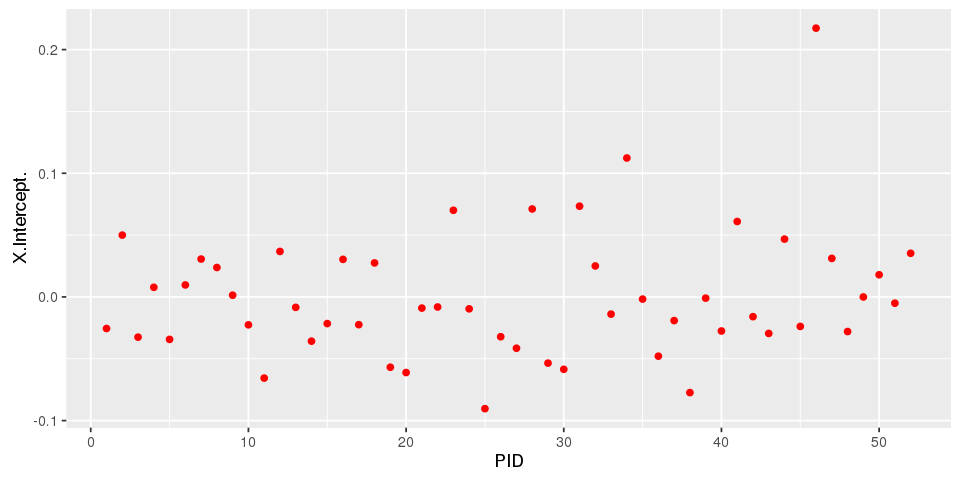

ERROR: Error: Don't know how to add stat_qq to a plot


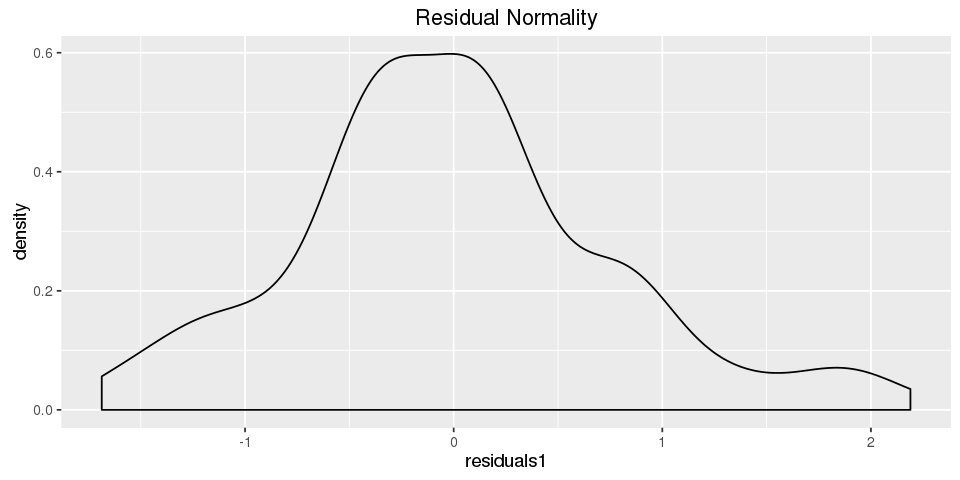

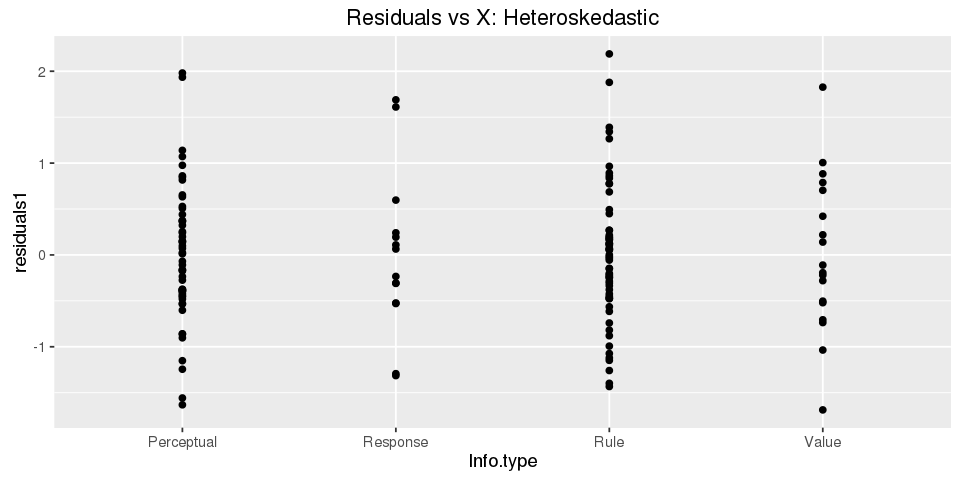

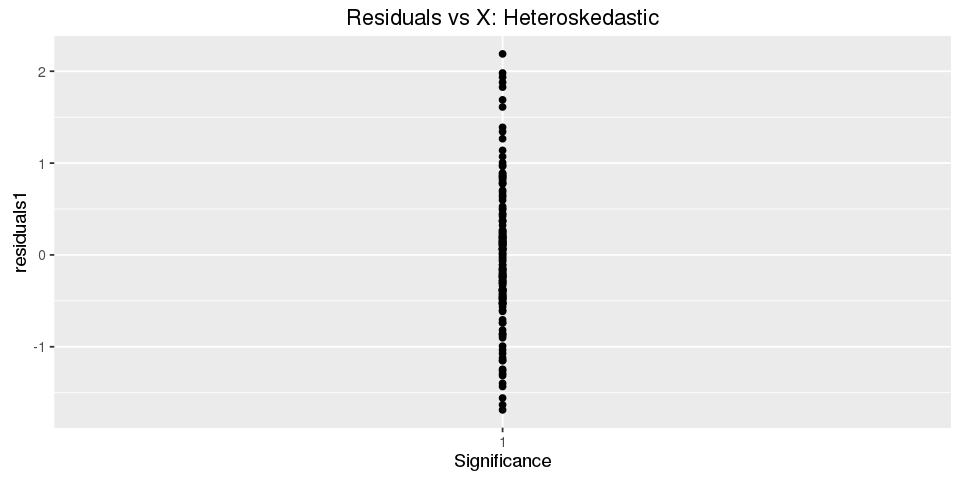

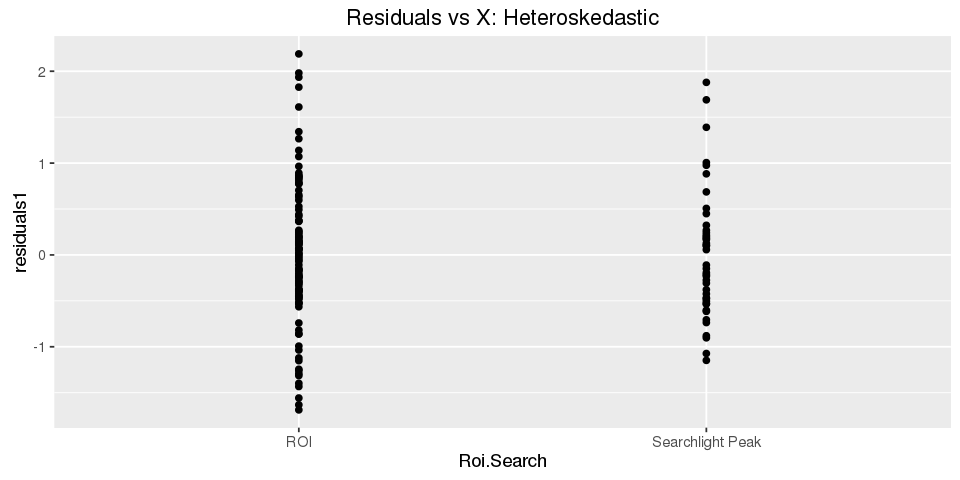

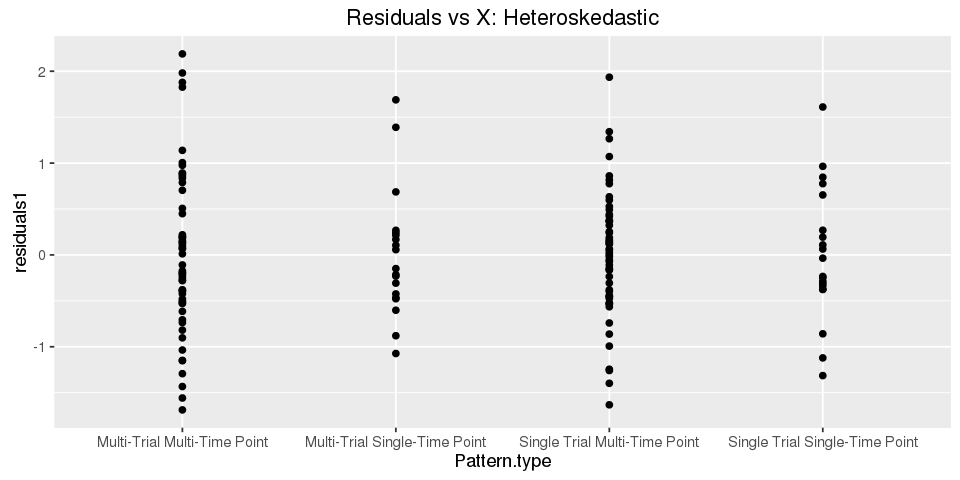

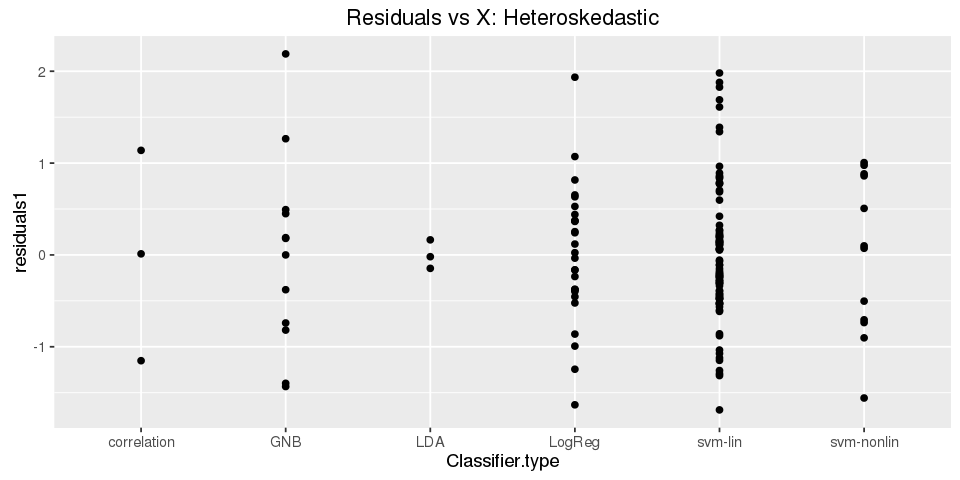

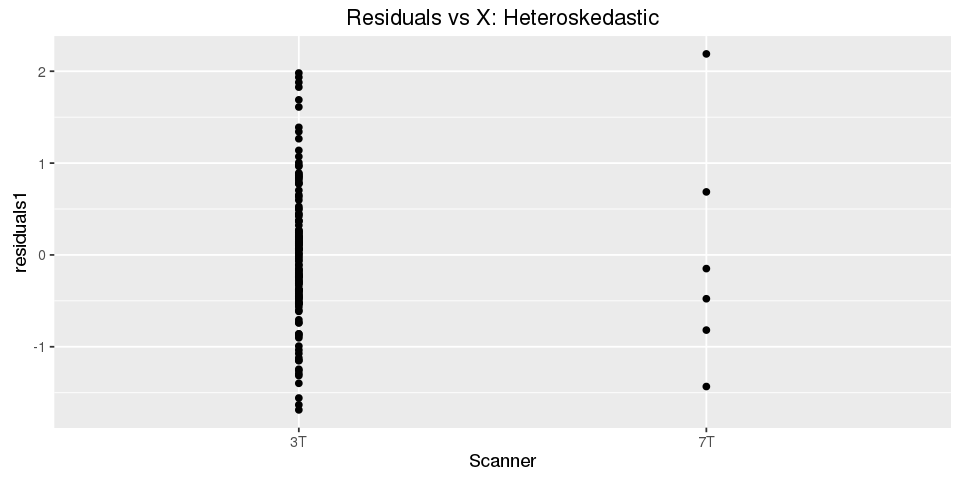

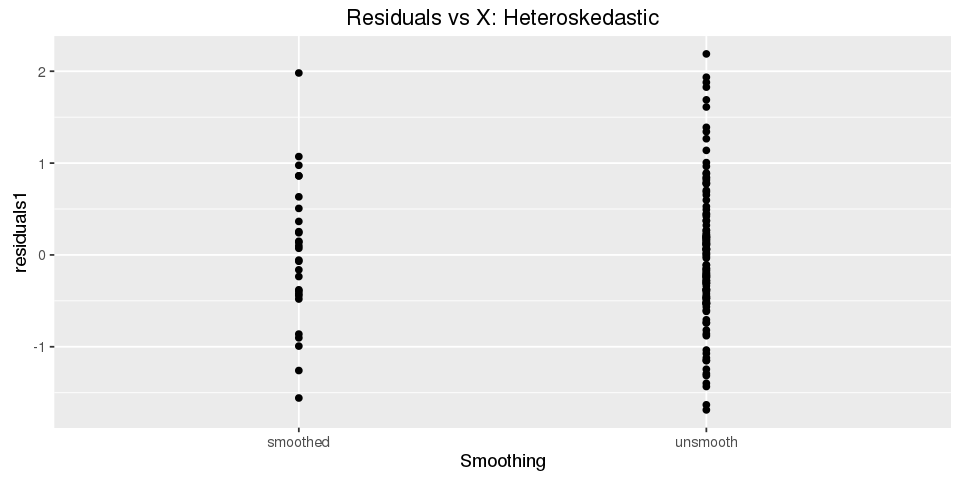

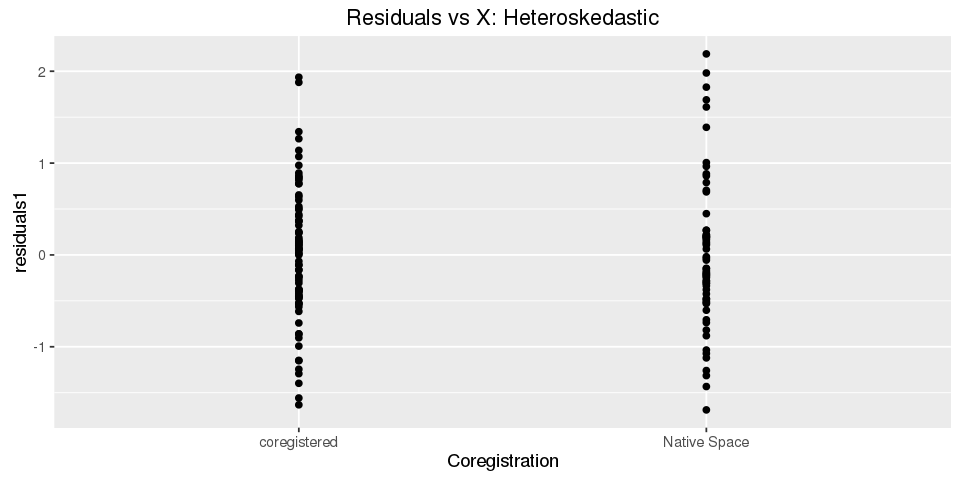

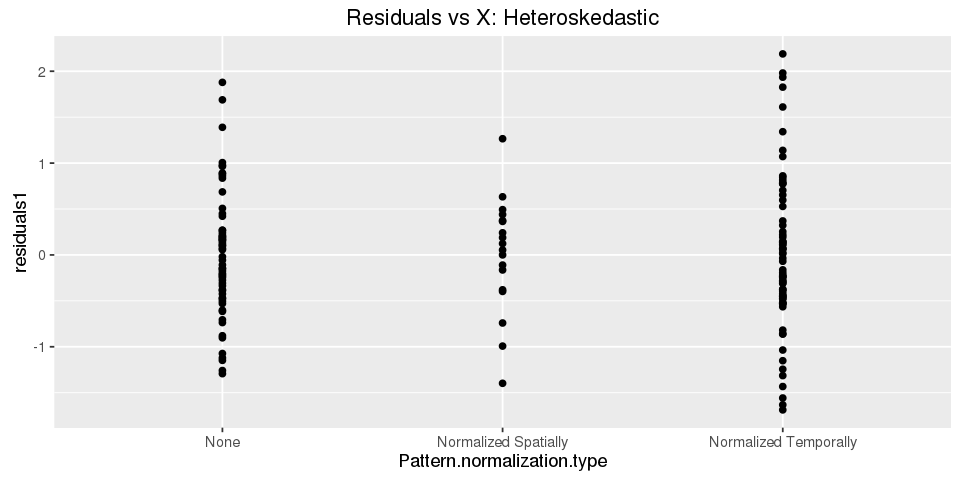

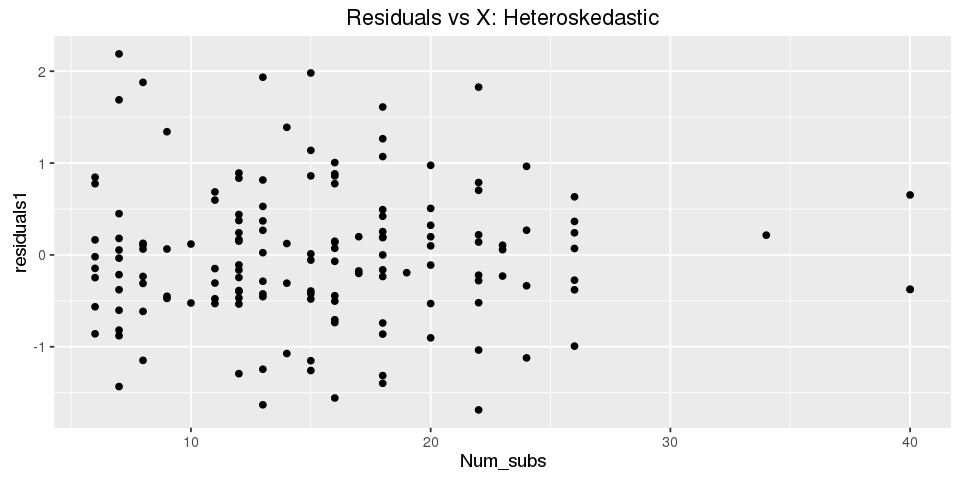

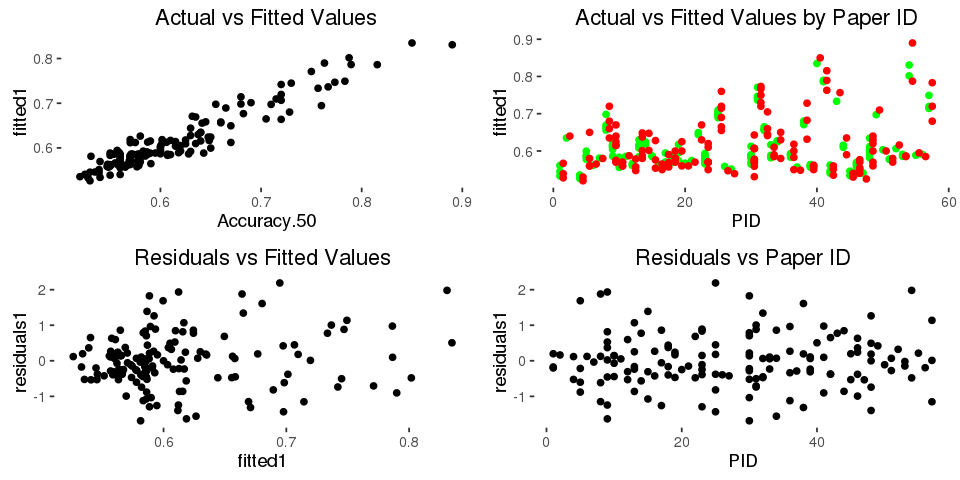

In [257]:
d$residuals1 = residuals(full_model, level = 1,type = c("pearson"))
d$residuals0 = residuals(full_model, level = 0,type = c("pearson"))
d$fitted1 = fitted(full_model, level = 1)
d$fitted0 = fitted(full_model, level = 0)

options(repr.plot.width=8, repr.plot.height=4)

# quality of fit
p1<- ggplot(aes(y = fitted1, x = Accuracy.50), data = d) +geom_point()+ggtitle("Actual vs Fitted Values")+theme(panel.background=element_blank())

d$PID5<-as.numeric(d$PID)+.5
d$PID<-as.numeric(d$PID)

ddd<-data.frame(PID=row.names(ranef(full_model)),studymean=ranef(full_model)) # create a new dataframe with random effects
ddd$PID<-as.numeric(ddd$PID)

p2<- ggplot(aes(y = fitted1, x = PID), data = d) +geom_point(color='green')+theme(panel.background=element_blank())+
geom_point(color='red',aes(y = Accuracy.50, x = PID5))+
ggtitle('Actual vs Fitted Values by Paper ID')



ggplot()+geom_point(data=ddd,color='red',aes(y=X.Intercept., x = PID))

ggplot(aes(x = residuals1),data=d)+geom_density()+ggtitle('Residual Normality')
ggplot(aes(x = residuals1),data=d)+stat_qq+ggtitle('Residual Normality')


p3<-ggplot(aes(y = residuals1,x=fitted1), data = d)+geom_point()+ggtitle('Residuals vs Fitted Values')+theme(panel.background=element_blank())

#ggplot(aes(y = residuals0,x=PID), data = d)+geom_point()
p4<-ggplot(aes(y = residuals1,x=PID), data = d)+geom_point()+ggtitle('Residuals vs Paper ID')+theme(panel.background=element_blank())



for (f in factors){
        p<-ggplot(aes_string(y = 'residuals1',x=f), data = d)+geom_point()+ggtitle('Residuals vs X: Heteroskedastic')
        print(p)
}


lay <- rbind(c(1,2),
             c(3,4))


grid.arrange(p1,p2,p3,p4,layout_matrix = lay)

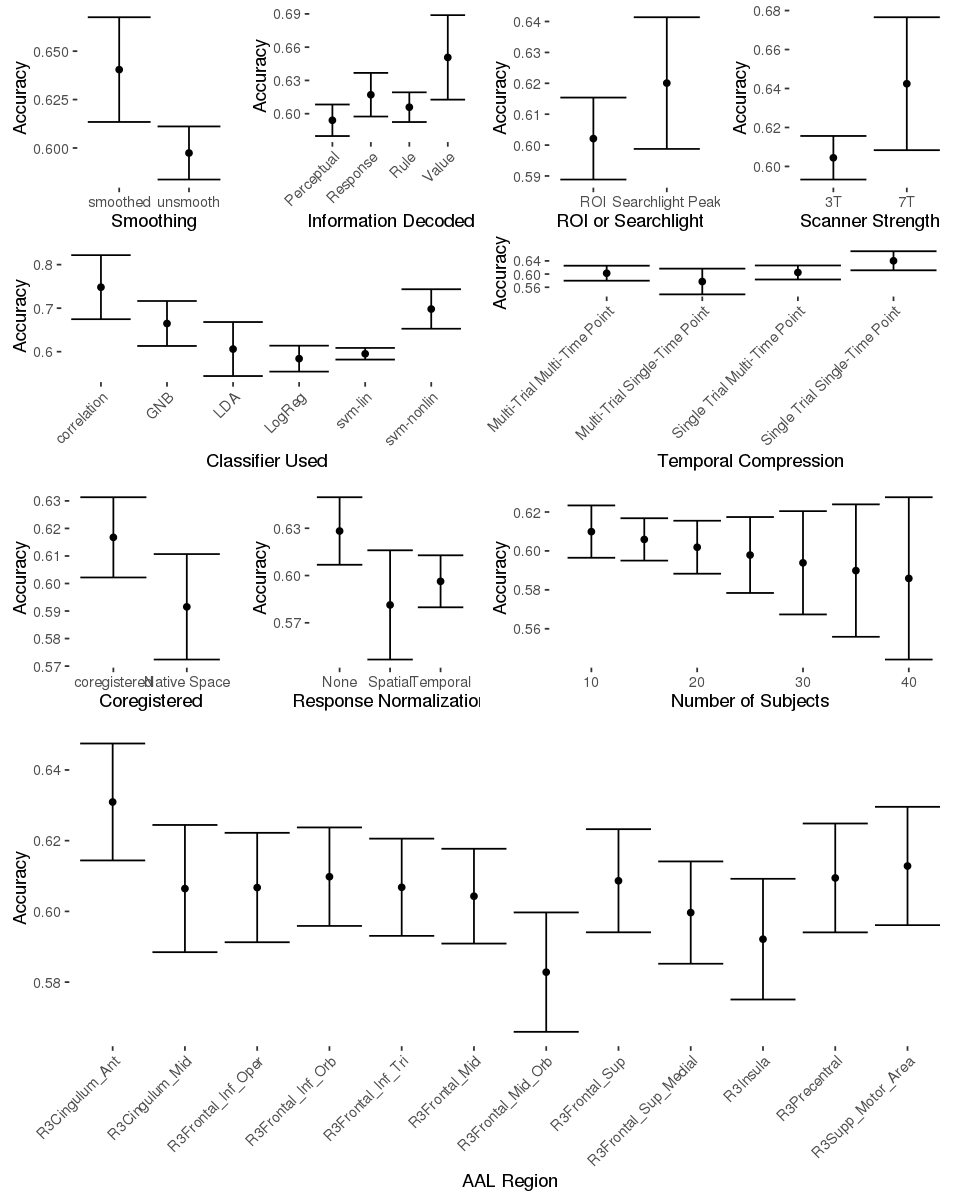

In [288]:
options(repr.plot.width=8, repr.plot.height=10)


feature='Smoothing'
dd<-data.frame(effect(feature,full_model))
dd$Accuracy<-dd$fit
dd$Smoothing<-dd[,feature]
p1 <-ggplot(aes(y = Accuracy, x = Smoothing,ymax = Accuracy + se, ymin=Accuracy - se), data = dd) +geom_point()+geom_errorbar()+xlab('Smoothing')

feature='Info.type'
dd<-data.frame(effect(feature,full_model))
dd$Accuracy<-dd$fit
dd$Info.type<-dd[,feature]
p2 <-ggplot(aes(y = Accuracy, x = Info.type,ymax = Accuracy + se, ymin=Accuracy - se), data = dd) +geom_point()+geom_errorbar()+theme(axis.text.x = element_text(angle = 45, hjust = 1))+xlab('Information Decoded')

feature='Roi.Search'
dd<-data.frame(effect(feature,full_model))
dd$Accuracy<-dd$fit
dd$Roi_or_Searchlight<-dd[,feature]
p3 <-ggplot(aes(y = Accuracy, x = Roi_or_Searchlight,ymax = Accuracy + se, ymin=Accuracy - se), data = dd) +geom_point()+geom_errorbar()+xlab('ROI or Searchlight')

feature='Classifier.type'
dd<-data.frame(effect(feature,full_model))
dd$Accuracy<-dd$fit
dd$Classifier.type<-dd[,feature]
p4 <-ggplot(aes(y = Accuracy, x = Classifier.type,ymax = Accuracy + se, ymin=Accuracy - se), data = dd) +geom_point()+geom_errorbar()+theme(axis.text.x = element_text(angle = 45, hjust = 1))+xlab('Classifier Used')


feature='Scanner'
dd<-data.frame(effect(feature,full_model))
dd$Accuracy<-dd$fit
dd$Scanner.strength<-dd[,feature]
p5 <-ggplot(aes(y = Accuracy, x = Scanner.strength,ymax = Accuracy + se, ymin=Accuracy - se), data = dd) +geom_point()+geom_errorbar()+xlab('Scanner Strength')

feature='Coregistration'
dd<-data.frame(effect(feature,full_model))
dd$Accuracy<-dd$fit
dd$Coregistrated<-dd[,feature]
p6 <-ggplot(aes(y = Accuracy, x = Coregistrated,ymax = Accuracy + se, ymin=Accuracy - se), data = dd) +geom_point()+geom_errorbar()+xlab('Coregistered')

feature='Pattern.normalization.type'
dd<-data.frame(effect(feature,full_model))
dd$Accuracy<-dd$fit
dd$Pattern.normalization.type<-dd[,feature]
p7 <-ggplot(aes(y = Accuracy, x = Pattern.normalization.type,ymax = Accuracy + se, ymin=Accuracy - se), data = dd) +geom_point()+geom_errorbar()+xlab('Response Normalization')
p7<-p7 + scale_x_discrete(labels=c('None','Spatial','Temporal'))

#theme(axis.text.x = element_text(angle = 45, hjust = 1))

feature='Num_subs'
dd<-data.frame(effect(feature,full_model))
dd$Accuracy<-dd$fit
dd$Feature<-dd[,feature]
p8 <-ggplot(aes(y = Accuracy, x = Feature,ymax = Accuracy + se, ymin=Accuracy - se), data = dd) +geom_point()+geom_errorbar()+xlab('Number of Subjects')


feature='Pattern.type'
dd<-data.frame(effect(feature,full_model))
dd$Accuracy<-dd$fit
dd$Pattern.normalization.type<-dd[,feature]
p9 <-ggplot(aes(y = Accuracy, x = Pattern.normalization.type,ymax = Accuracy + se, ymin=Accuracy - se), data = dd) +geom_point()+geom_errorbar()+theme(axis.text.x = element_text(angle = 45, hjust = 1))+xlab('Temporal Compression')





## Regions
fits<-c()
se<-c()
i=1
for (name in R3names){
    ef<-effect(name,full_model)
    fits[i]<-tail(ef$fit, n=1)
    se[i]<-tail(ef$se, n=1)
    i=i+1
    
}
dd = data.table(name=R3names,se=se,Accuracy=fits)
p10 <- ggplot(aes(y = Accuracy, x = name,ymax = Accuracy + se, ymin=Accuracy - se), data = dd) +geom_point()+geom_errorbar()+theme(axis.text.x = element_text(angle = 45, hjust = 1))
p10<-p10+xlab('AAL Region')

p1<-p1+theme(panel.background=element_blank())
p2<-p2+theme(panel.background=element_blank())
p3<-p3+theme(panel.background=element_blank())
p4<-p4+theme(panel.background=element_blank())
p5<-p5+theme(panel.background=element_blank())
p6<-p6+theme(panel.background=element_blank())
p7<-p7+theme(panel.background=element_blank())
p8<-p8+theme(panel.background=element_blank())
p9<-p9+theme(panel.background=element_blank())
p10<-p10+theme(panel.background=element_blank())

lay <- rbind(c(1,2,3,5),
             c(4,4,9,9),
             c(6,7,8,8),
             c(10,10,10,10),
            c(10,10,10,10))

grid.arrange(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10 ,layout_matrix = lay)


## Corelation of Factors

In [128]:

X = model.matrix(full_model,data=data_50_sig_unique)
X<-X[,2:ncol(X)]
C = cor(X)
#colMeans(X)

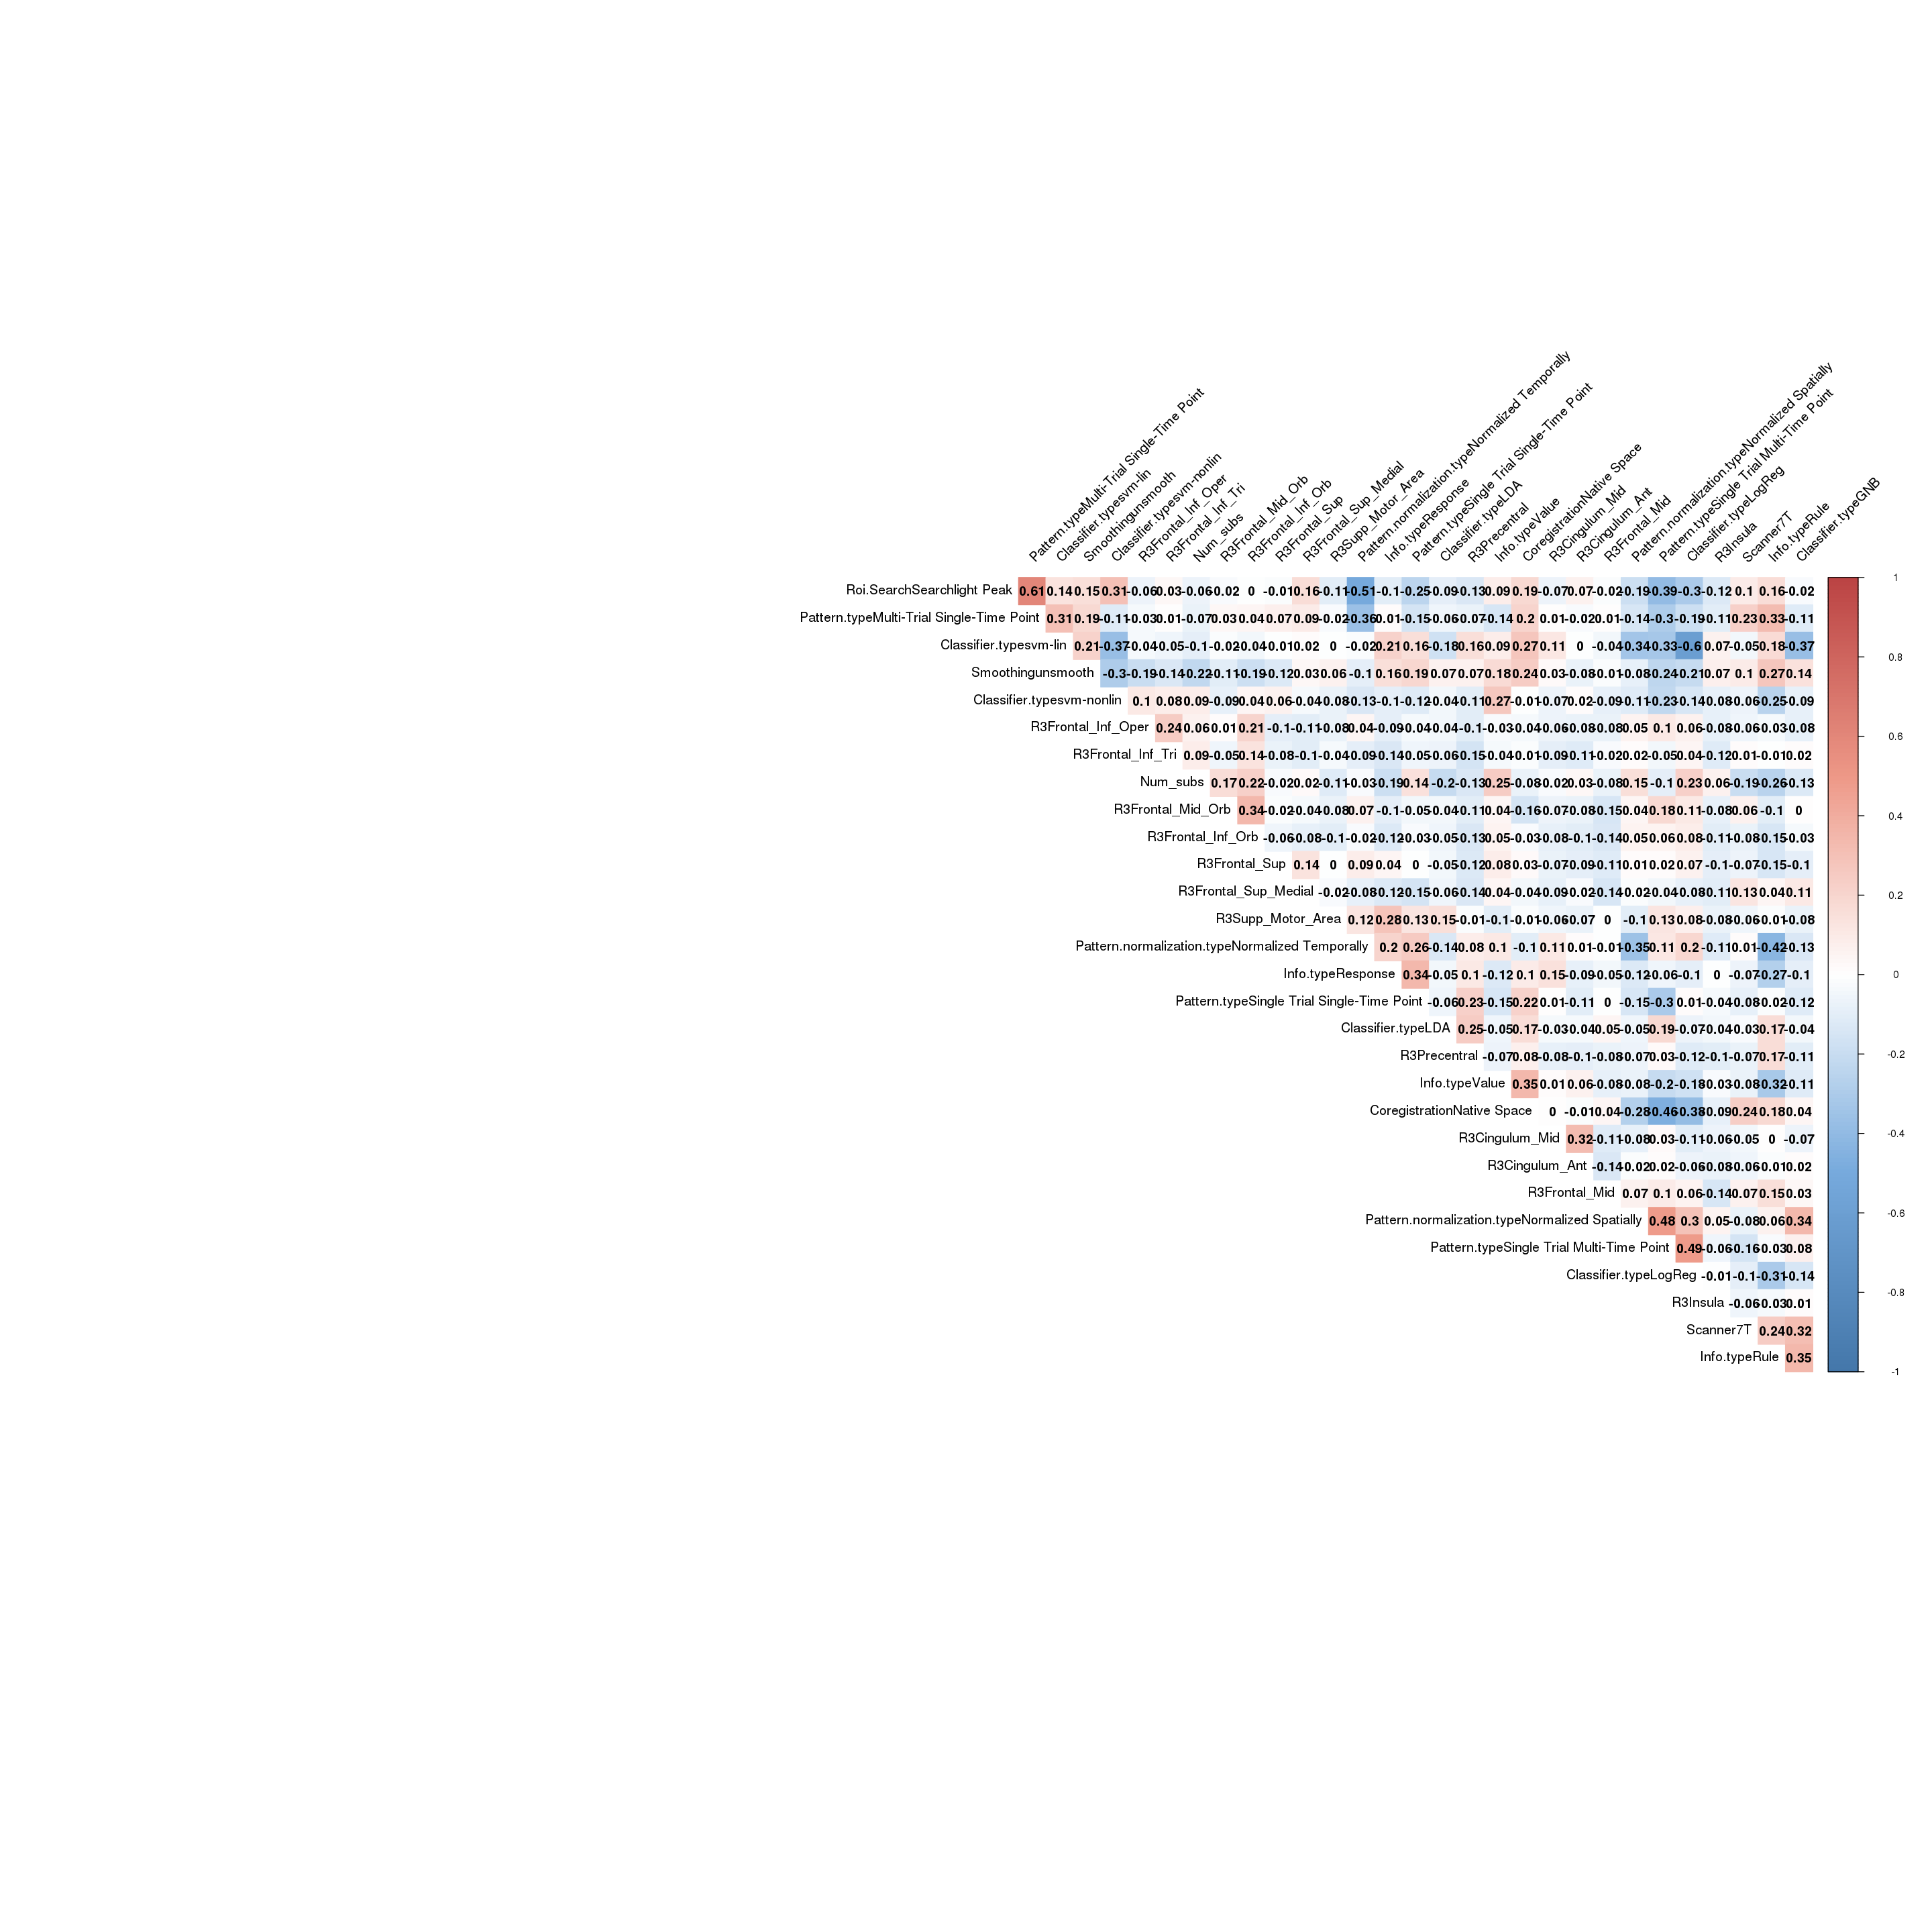

In [132]:

col <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"))
col <- colorRampPalette(c("#4477AA", "#77AADD", "#FFFFFF","#EE9988", "#BB4444"))
options(repr.plot.width=24, repr.plot.height=24)
corrplot(C, method="color", col=col(200),  
         type="upper", order="hclust", 
         addCoef.col = "black", # Add coefficient of correlation
         tl.col="black", tl.srt=45, #Text label color and rotation
         # Combine with significance
         # hide correlation coefficient on the principal diagonal
         diag=FALSE 
         )

## OLS, Sig, Unique, All Factors

In [259]:
d<-data_50_sig_unique[c('Accuracy.50','PID',factors,R3names)]

full_model_ols<-gls(Accuracy.50~Info.type+Roi.Search+Pattern.type+Classifier.type+Scanner+
                Smoothing+Coregistration+Pattern.normalization.type+Num_subs+
                R3Precentral+R3Frontal_Mid+R3Frontal_Mid_Orb+R3Frontal_Inf_Orb+R3Frontal_Inf_Oper+R3Frontal_Inf_Tri+
                R3Supp_Motor_Area+R3Cingulum_Mid+R3Cingulum_Ant+R3Frontal_Sup+R3Frontal_Sup_Medial+R3Insula,data=d,method='REML')

#summary(full_model_ols)

In [42]:
#anova(full_model_ols,full_model)

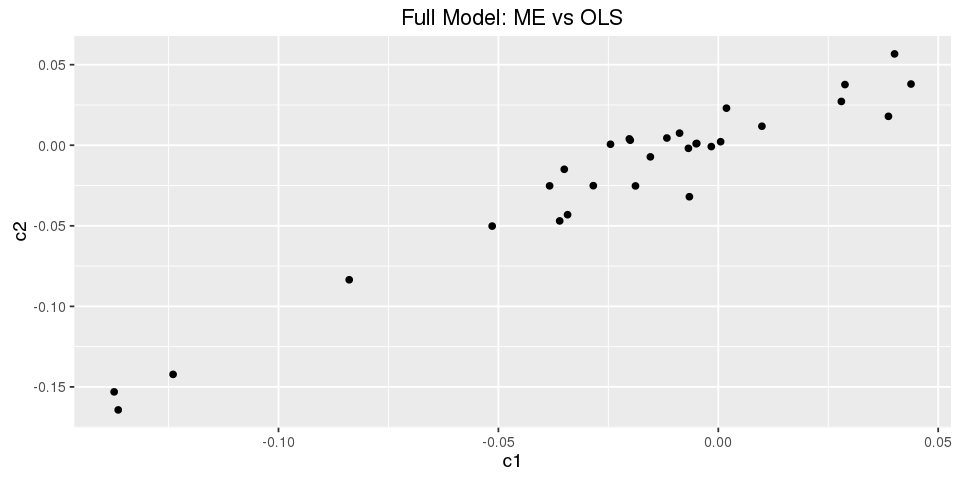

In [260]:
options(repr.plot.width=8, repr.plot.height=4)

c1<-coef(full_model_ols)
c2<-summary(full_model)$coef$fixed
c1<-c1[2:length(c1)]
c2<-c2[2:length(c2)]
qplot(c1,c2)+ggtitle('Full Model: ME vs OLS')

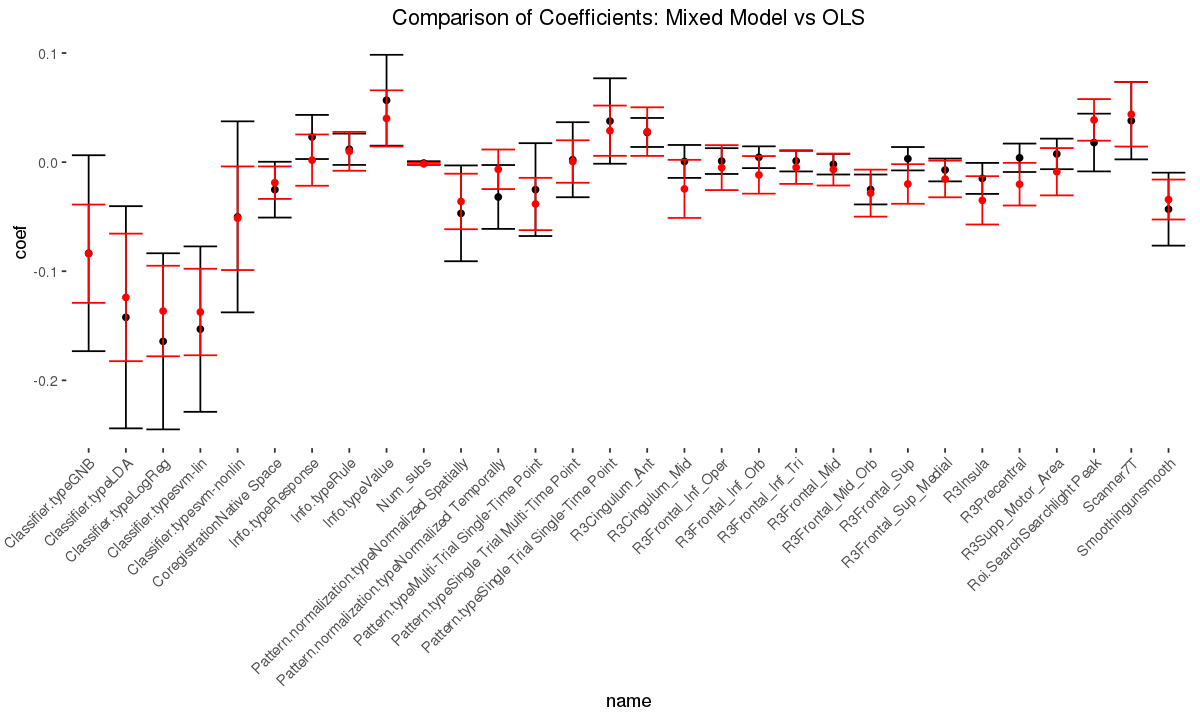

In [263]:
options(repr.plot.width=10, repr.plot.height=6)

# full model
s<-summary(full_model)
coef<-s$tTable[,1] 
se<-s$tTable[,2] 
df<-data.frame(cbind(coef,se))

# other model
s<-summary(full_model_ols)
coef<-s$tTable[,1] 
se<-s$tTable[,2] 
df$coef_new<-coef
df$se_new<-se

df$name<-rownames(df)
df<-df[2:nrow(df),] # remove intercept 
ggplot(data=df,aes(x=name))+
geom_point(aes(y=coef))+
geom_errorbar(aes(ymax = coef + se, ymin=coef- se))+
geom_point(color='red',aes(y=coef_new))+
geom_errorbar(color='red',aes(ymax = coef_new + se_new, ymin=coef_new- se_new))+
theme(axis.text.x = element_text(angle = 45, hjust = 1))+
ggtitle('Comparison of Coefficients: Mixed Model vs OLS')+theme(panel.background=element_blank())

## Mixed Effects, Sig, All Factors

In [267]:
d<-data_50_sig[c('Accuracy.50','PID',factors,R3names)]

full_model_nonunique<-lme(Accuracy.50~Info.type+Roi.Search+Pattern.type+Classifier.type+Scanner+
                Smoothing+Coregistration+Pattern.normalization.type+Num_subs+
                R3Precentral+R3Frontal_Mid+R3Frontal_Mid_Orb+R3Frontal_Inf_Orb+R3Frontal_Inf_Oper+R3Frontal_Inf_Tri+
                R3Supp_Motor_Area+R3Cingulum_Mid+R3Cingulum_Ant+R3Frontal_Sup+R3Frontal_Sup_Medial+R3Insula,random=~1|PID,data=d,method='REML')



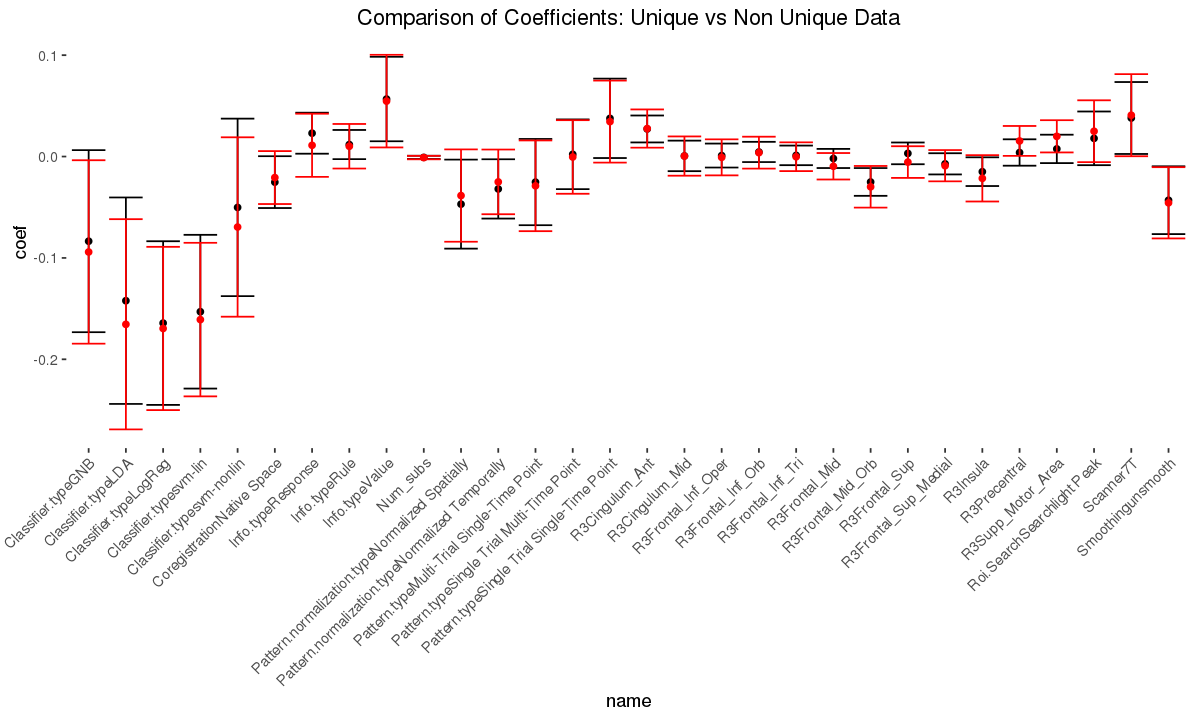

In [269]:
options(repr.plot.width=10, repr.plot.height=6)

# full model
s<-summary(full_model)
coef<-s$tTable[,1] 
se<-s$tTable[,2] 
df<-data.frame(cbind(coef,se))

# other model
s<-summary(full_model_nonunique)
coef<-s$tTable[,1] 
se<-s$tTable[,2] 
df$coef_new<-coef
df$se_new<-se

df$name<-rownames(df)
df<-df[2:nrow(df),] # remove intercept 
ggplot(data=df,aes(x=name))+
geom_point(aes(y=coef))+
geom_errorbar(aes(ymax = coef + se, ymin=coef- se))+
geom_point(color='red',aes(y=coef_new))+
geom_errorbar(color='red',aes(ymax = coef_new + se_new, ymin=coef_new- se_new))+
theme(axis.text.x = element_text(angle = 45, hjust = 1))+
ggtitle('Comparison of Coefficients: Unique vs Non Unique Data')+theme(panel.background=element_blank())

## Mixed Effects, Sig and Non, Unique, All Factors

In [271]:
d<-data_50_unique[c('Accuracy.50','PID',factors,R3names)]

full_model_sig_non_unique<-lme(Accuracy.50~Info.type+Roi.Search+Pattern.type+Classifier.type+Scanner+
                Smoothing+Coregistration+Pattern.normalization.type+Num_subs+
                R3Precentral+R3Frontal_Mid+R3Frontal_Mid_Orb+R3Frontal_Inf_Orb+R3Frontal_Inf_Oper+R3Frontal_Inf_Tri+
                R3Supp_Motor_Area+R3Cingulum_Mid+R3Cingulum_Ant+R3Frontal_Sup+R3Frontal_Sup_Medial+R3Insula,random=~1|PID,data=d,method='REML')



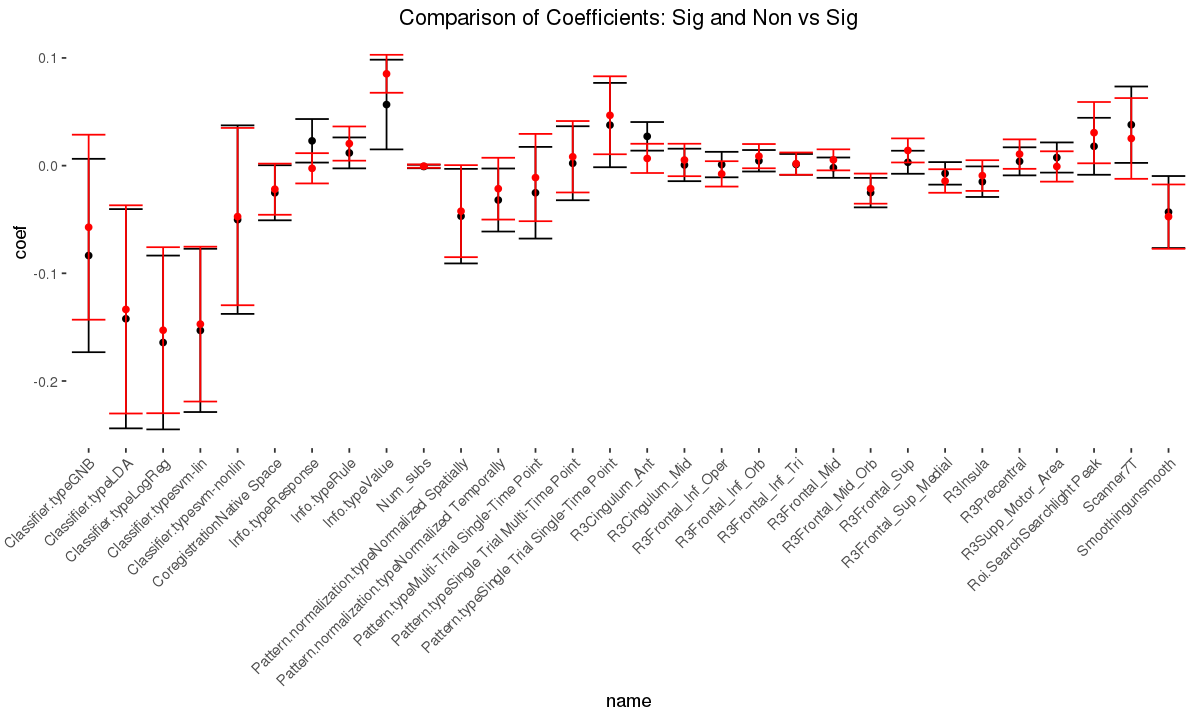

In [272]:

options(repr.plot.width=10, repr.plot.height=6)
# full model
s<-summary(full_model)
coef<-s$tTable[,1] 
se<-s$tTable[,2] 
df<-data.frame(cbind(coef,se))

# other model
s<-summary(full_model_sig_non_unique)
coef<-s$tTable[,1] 
se<-s$tTable[,2] 
df$coef_new<-coef
df$se_new<-se

df$name<-rownames(df)
df<-df[2:nrow(df),] # remove intercept 
ggplot(data=df,aes(x=name))+
geom_point(aes(y=coef))+
geom_errorbar(aes(ymax = coef + se, ymin=coef- se))+
geom_point(color='red',aes(y=coef_new))+
geom_errorbar(color='red',aes(ymax = coef_new + se_new, ymin=coef_new- se_new))+
theme(axis.text.x = element_text(angle = 45, hjust = 1))+
ggtitle('Comparison of Coefficients: Sig and Non vs Sig')+theme(panel.background=element_blank())

## Factor Only

In [281]:
d<-data_50_unique[c('Accuracy.50','PID',factors,R3names)]


factor_model<-lme(Accuracy.50~Info.type+Roi.Search+Pattern.type+Classifier.type+Scanner+
                Smoothing+Coregistration+Pattern.normalization.type+Num_subs,random=~1|PID,data=d,method='ML')



factor_model_wo_Classifier.type<-update(factor_model,.~. -Classifier.type)
factor_model_wo_Info.type<-update(factor_model,.~. -Info.type)
factor_model_wo_Smoothing<-update(factor_model,.~. -Smoothing)
factor_model_wo_Coregistration<-update(factor_model,.~. -Coregistration)
factor_model_wo_Pattern.normalization.type<-update(factor_model,.~. -Pattern.normalization.type)
factor_model_wo_Num_subs<-update(factor_model,.~. -Num_subs)
factor_model_wo_Scanner<-update(factor_model,.~. -Scanner)
factor_model_wo_Pattern.type<-update(factor_model,.~. -Pattern.type)


a <-anova(factor_model,factor_model_wo_Classifier.type)
data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
a <-anova(factor_model,factor_model_wo_Info.type)
data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
a <-anova(factor_model,factor_model_wo_Smoothing)
data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
a <-anova(factor_model,factor_model_wo_Coregistration)
data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
a <-anova(factor_model,factor_model_wo_Pattern.normalization.type)
data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
a <-anova(factor_model,factor_model_wo_Num_subs)
data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
a <-anova(factor_model,factor_model_wo_Scanner)
data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
a <-anova(factor_model,factor_model_wo_Pattern.type)
data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]


summary(factor_model)
anova(factor_model,region_model_wo_region)

Model df       AIC       BIC   logLik  L.Ratio
factor_model                        1 21 -710.7968 -637.2704 376.3984       NA
factor_model_wo_Classifier.type     2 16 -705.6857 -649.6656 368.8429 15.11107
                                    p.value
factor_model                             NA
factor_model_wo_Classifier.type 0.009898132

Model df       AIC       BIC   logLik  L.Ratio
factor_model                  1 21 -710.7968 -637.2704 376.3984       NA
factor_model_wo_Info.type     2 18 -687.8785 -624.8559 361.9393 28.91826
                               p.value
factor_model                        NA
factor_model_wo_Info.type 2.329763e-06

Model df       AIC       BIC   logLik  L.Ratio
factor_model                  1 21 -710.7968 -637.2704 376.3984       NA
factor_model_wo_Smoothing     2 20 -709.3459 -639.3207 374.6729 3.450896
                            p.value
factor_model                     NA
factor_model_wo_Smoothing 0.0632175

Model df       AIC       BIC   logLik  L.Ratio
factor_model                       1 21 -710.7968 -637.2704 376.3984       NA
factor_model_wo_Coregistration     2 20 -712.0633 -642.0382 376.0317 0.733464
                                 p.value
factor_model                          NA
factor_model_wo_Coregistration 0.3917627

Model df       AIC       BIC
factor_model                                   1 21 -710.7968 -637.2704
factor_model_wo_Pattern.normalization.type     2 19 -713.7341 -647.2102
                                             logLik  L.Ratio   p.value
factor_model                               376.3984       NA        NA
factor_model_wo_Pattern.normalization.type 375.8670 1.062715 0.5878064

Model df       AIC       BIC   logLik   L.Ratio
factor_model                 1 21 -710.7968 -637.2704 376.3984        NA
factor_model_wo_Num_subs     2 20 -712.3442 -642.3191 376.1721 0.4525534
                           p.value
factor_model                    NA
factor_model_wo_Num_subs 0.5011249

Model df       AIC       BIC   logLik   L.Ratio
factor_model                1 21 -710.7968 -637.2704 376.3984        NA
factor_model_wo_Scanner     2 20 -712.5173 -642.4921 376.2586 0.2795029
                          p.value
factor_model                   NA
factor_model_wo_Scanner 0.5970272

Model df       AIC       BIC   logLik  L.Ratio
factor_model                     1 21 -710.7968 -637.2704 376.3984       NA
factor_model_wo_Pattern.type     2 18 -713.8022 -650.7795 374.9011 2.994594
                               p.value
factor_model                        NA
factor_model_wo_Pattern.type 0.3924595

Linear mixed-effects model fit by maximum likelihood
 Data: d 
        AIC       BIC   logLik
  -710.7968 -637.2704 376.3984

Random effects:
 Formula: ~1 | PID
        (Intercept)   Residual
StdDev:    0.046707 0.04391725

Fixed effects: Accuracy.50 ~ Info.type + Roi.Search + Pattern.type + Classifier.type +      Scanner + Smoothing + Coregistration + Pattern.normalization.type +      Num_subs 
                                                     Value  Std.Error  DF
(Intercept)                                      0.7543254 0.06973279 187
Info.typeResponse                               -0.0024846 0.01411483 187
Info.typeRule                                    0.0218179 0.01525148 187
Info.typeValue                                   0.0832562 0.01763118 187
Roi.SearchSearchlight Peak                       0.0296965 0.02490416 187
Pattern.typeMulti-Trial Single-Time Point       -0.0106733 0.03418725  39
Pattern.typeSingle Trial Multi-Time Point        0.0050540 0.02751400  39
Pattern.t

Model df       AIC       BIC   logLik   Test  L.Ratio
factor_model               1 21 -710.7968 -637.2704 376.3984                
region_model_wo_region     2  3 -689.9967 -679.4929 347.9983 1 vs 2 56.80009
                       p-value
factor_model                  
region_model_wo_region  <.0001

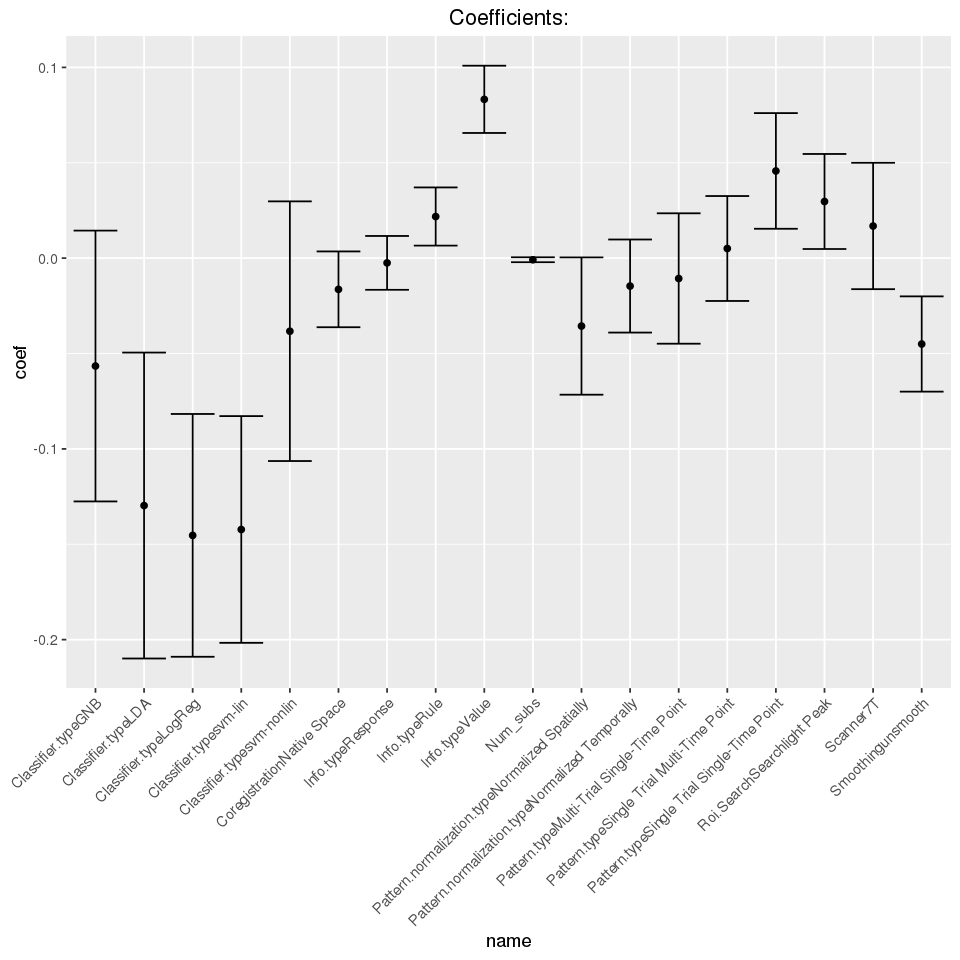

In [282]:
options(repr.plot.width=8, repr.plot.height=8)

# full model
s<-summary(factor_model)
coef<-s$tTable[,1] 
se<-s$tTable[,2] 
df<-data.frame(cbind(coef,se))

df$name<-rownames(df)
df<-df[2:nrow(df),] # remove intercept 
ggplot(data=df,aes(x=name))+
geom_point(aes(y=coef))+
geom_errorbar(aes(ymax = coef + se, ymin=coef- se))+

theme(axis.text.x = element_text(angle = 45, hjust = 1))+
ggtitle('Coefficients:')

## Region Alone

In [273]:
d<-data_50_unique[c('Accuracy.50','PID',factors,R3names)]

region_model<-lme(Accuracy.50~
                R3Precentral+R3Frontal_Mid+R3Frontal_Mid_Orb+R3Frontal_Inf_Orb+R3Frontal_Inf_Oper+R3Frontal_Inf_Tri+
                R3Supp_Motor_Area+R3Cingulum_Mid+R3Cingulum_Ant+R3Frontal_Sup+R3Frontal_Sup_Medial+R3Insula,random=~1|PID,data=d,method='ML')
region_model_wo_region<-lme(Accuracy.50~
                1,random=~1|PID,data=d,method='ML')


summary(region_model)
anova(region_model,region_model_wo_region)

Linear mixed-effects model fit by maximum likelihood
 Data: d 
        AIC       BIC   logLik
  -673.1752 -620.6563 351.5876

Random effects:
 Formula: ~1 | PID
        (Intercept)   Residual
StdDev:  0.06802269 0.04593402

Fixed effects: Accuracy.50 ~ R3Precentral + R3Frontal_Mid + R3Frontal_Mid_Orb +      R3Frontal_Inf_Orb + R3Frontal_Inf_Oper + R3Frontal_Inf_Tri +      R3Supp_Motor_Area + R3Cingulum_Mid + R3Cingulum_Ant + R3Frontal_Sup +      R3Frontal_Sup_Medial + R3Insula 
                          Value  Std.Error  DF  t-value p-value
(Intercept)           0.5957099 0.01303015 181 45.71779  0.0000
R3Precentral          0.0065736 0.01425342 181  0.46119  0.6452
R3Frontal_Mid         0.0035126 0.01028369 181  0.34157  0.7331
R3Frontal_Mid_Orb    -0.0221025 0.01471880 181 -1.50165  0.1349
R3Frontal_Inf_Orb     0.0078314 0.01189721 181  0.65825  0.5112
R3Frontal_Inf_Oper   -0.0095527 0.01244249 181 -0.76775  0.4436
R3Frontal_Inf_Tri     0.0035915 0.01097633 181  0.32720  0.7439
R3Sup

Model df       AIC       BIC   logLik   Test  L.Ratio
region_model               1 15 -673.1752 -620.6563 351.5876                
region_model_wo_region     2  3 -689.9967 -679.4929 347.9983 1 vs 2 7.178523
                       p-value
region_model                  
region_model_wo_region  0.8456

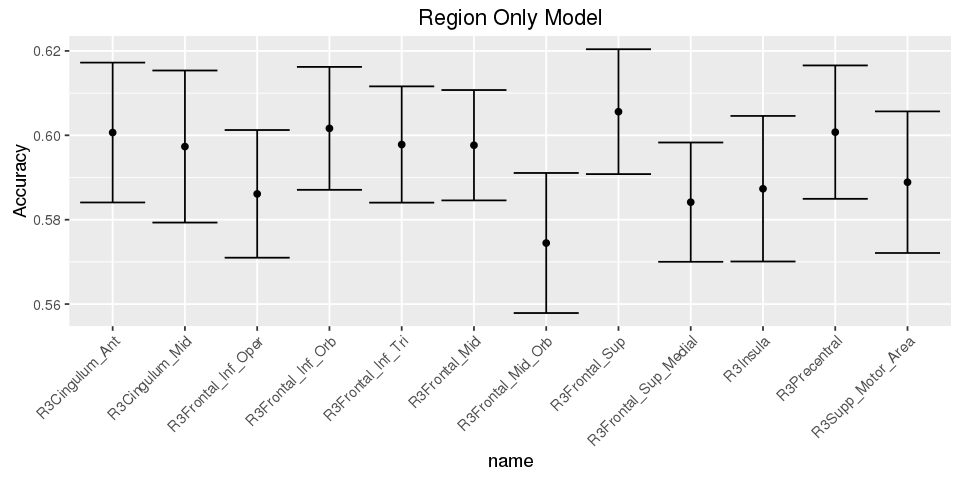

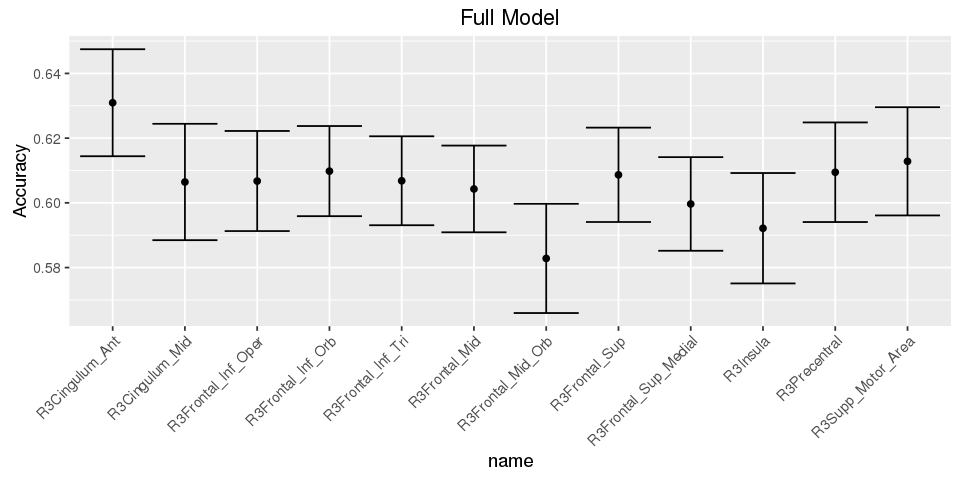

In [85]:
options(repr.plot.width=8, repr.plot.height=4)
fits<-c()
se<-c()
i=1
for (name in R3names){
    ef<-effect(name,region_model)
    fits[i]<-tail(ef$fit, n=1)
    se[i]<-tail(ef$se, n=1)
    i=i+1

    
}
dd = data.table(name=R3names,se=se,Accuracy=fits)
ggplot(aes(y = Accuracy, x = name,ymax = Accuracy + se, ymin=Accuracy - se), data = dd) +geom_point()+geom_errorbar()+theme(axis.text.x = element_text(angle = 45, hjust = 1))+ggtitle('Region Only Model')


fits<-c()
se<-c()
i=1
for (name in R3names){
    ef<-effect(name,full_model)
    fits[i]<-tail(ef$fit, n=1)
    se[i]<-tail(ef$se, n=1)
    i=i+1

    
}
dd = data.table(name=R3names,se=se,Accuracy=fits)
ggplot(aes(y = Accuracy, x = name,ymax = Accuracy + se, ymin=Accuracy - se), data = dd)+geom_point()+geom_errorbar()+theme(axis.text.x = element_text(angle = 45, hjust = 1))+ggtitle('Full Model')

## Region Model 6 Region

In [134]:
R4names

[1] "R4Frontal_Sup" "R4Frontal_Mid" "R4Frontal_Inf" "R4Insula"     
[5] "R4Motor"       "R4Cingulum"

In [275]:
d<-data_50_unique[c('Accuracy.50','PID',factors,R4names)]

region_model_reduced<-lme(Accuracy.50~R4Frontal_Sup+R4Frontal_Mid+R4Frontal_Inf+R4Insula+R4Cingulum+R4Motor,random=~1|PID,data=d,method='ML')


summary(region_model_reduced)



Linear mixed-effects model fit by maximum likelihood
 Data: d 
        AIC       BIC   logLik
  -679.0828 -647.5715 348.5414

Random effects:
 Formula: ~1 | PID
        (Intercept)   Residual
StdDev:  0.06739962 0.04672864

Fixed effects: Accuracy.50 ~ R4Frontal_Sup + R4Frontal_Mid + R4Frontal_Inf +      R4Insula + R4Cingulum + R4Motor 
                   Value   Std.Error  DF  t-value p-value
(Intercept)    0.5993550 0.014214278 187 42.16570  0.0000
R4Frontal_Sup -0.0074582 0.010282946 187 -0.72530  0.4692
R4Frontal_Mid -0.0021923 0.009931521 187 -0.22074  0.8255
R4Frontal_Inf -0.0043966 0.010295026 187 -0.42706  0.6698
R4Insula      -0.0119213 0.016404963 187 -0.72669  0.4683
R4Cingulum     0.0000714 0.014014254 187  0.00510  0.9959
R4Motor       -0.0015206 0.012942377 187 -0.11749  0.9066
 Correlation: 
              (Intr) R4Fr_S R4Fr_M R4Fr_I R4Insl R4Cngl
R4Frontal_Sup -0.518                                   
R4Frontal_Mid -0.512  0.417                            
R4Frontal_Inf 

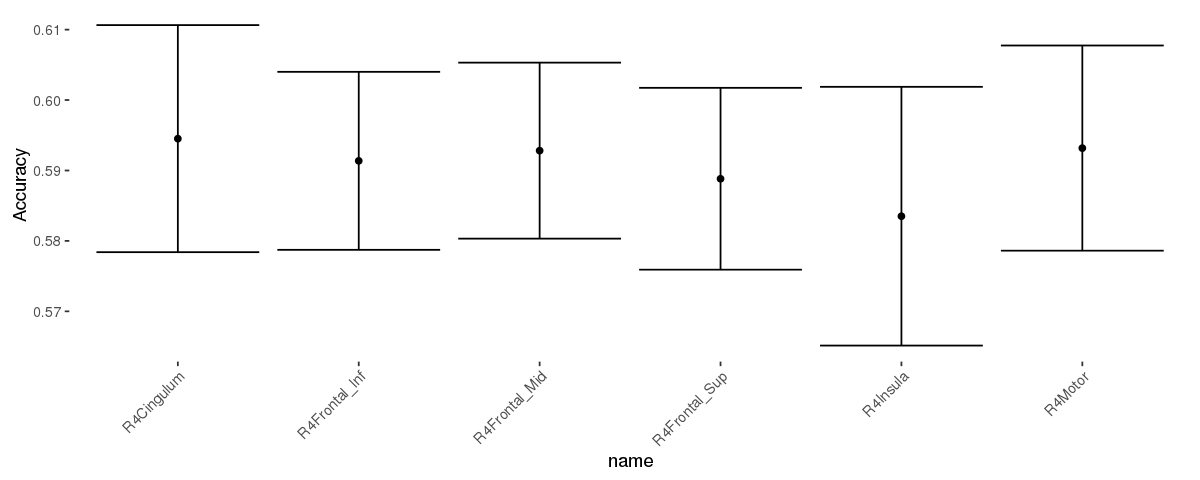

In [277]:
options(repr.plot.width=10, repr.plot.height=4)
fits<-c()
se<-c()
i=1
for (name in R4names){
    ef<-effect(name,region_model_reduced)
    fits[i]<-tail(ef$fit, n=1)
    se[i]<-tail(ef$se, n=1)
    i=i+1

    
}
dd = data.table(name=R4names,se=se,Accuracy=fits)
ggplot(aes(y = Accuracy, x = name,ymax = Accuracy + se, ymin=Accuracy - se), data = dd)+geom_point()+geom_errorbar()+theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(panel.background=element_blank())

## Region 6 Info Interaction

In [195]:
d<-data_50_unique[c('Accuracy.50','PID',factors,R4names)]

region_model_reduced_I1<-lme(Accuracy.50~Info.type+(R4Frontal_Sup+R4Frontal_Mid+R4Frontal_Inf+R4Insula+R4Cingulum+R4Motor),random=~1|PID,data=d,method='ML')

region_model_reduced_I2<-lme(Accuracy.50~Info.type*(R4Frontal_Sup+R4Frontal_Mid+R4Frontal_Inf+R4Insula+R4Cingulum+R4Motor),random=~1|PID,data=d,method='ML')
anova(region_model_reduced_I1,region_model_reduced_I2)

Model df       AIC       BIC   logLik   Test  L.Ratio
region_model_reduced_I1     1 12 -701.6798 -659.6647 362.8399                
region_model_reduced_I2     2 30 -674.8372 -569.7994 367.4186 1 vs 2 9.157354
                        p-value
region_model_reduced_I1        
region_model_reduced_I2   0.956

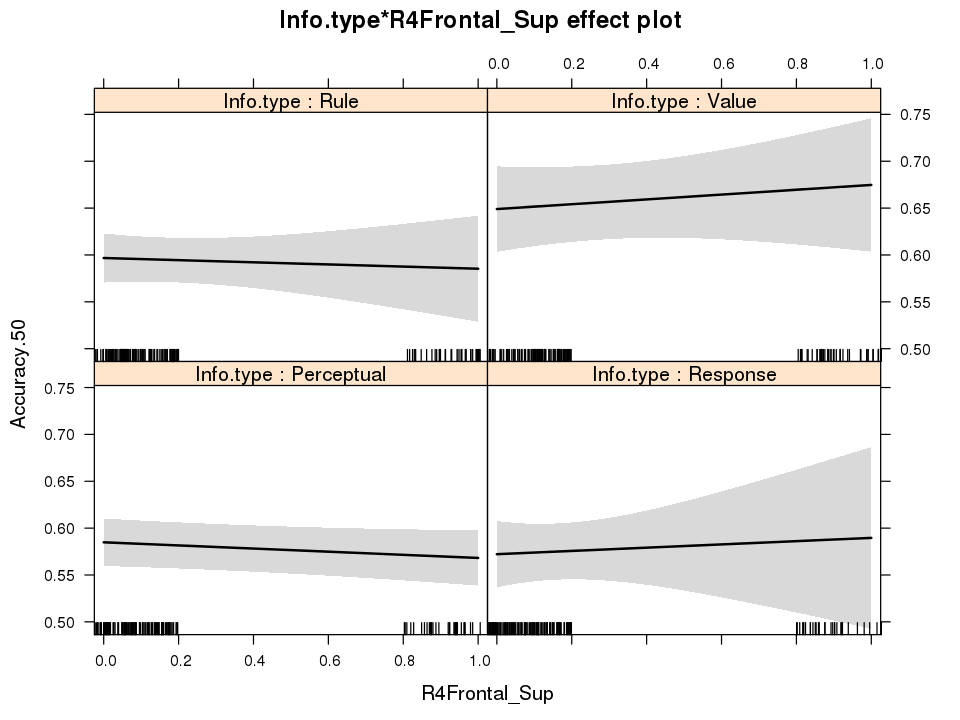

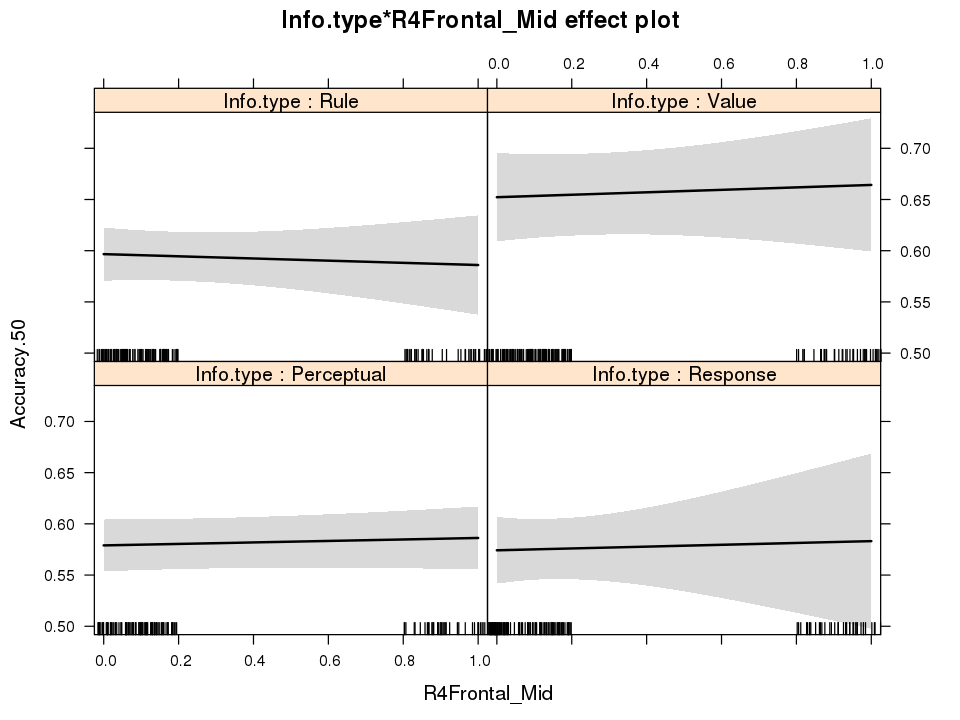

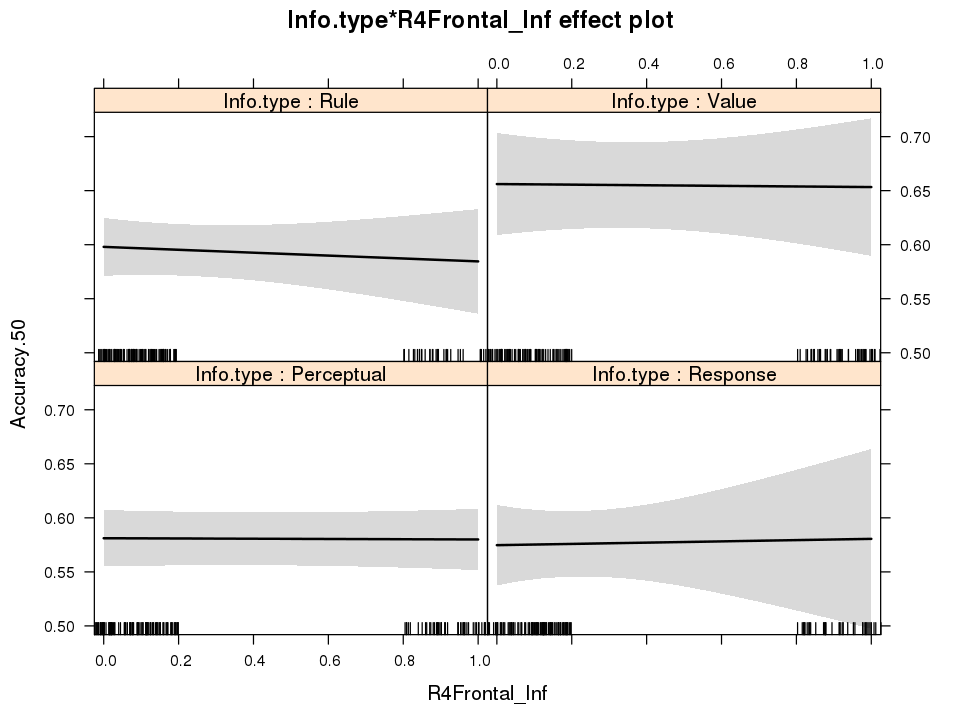

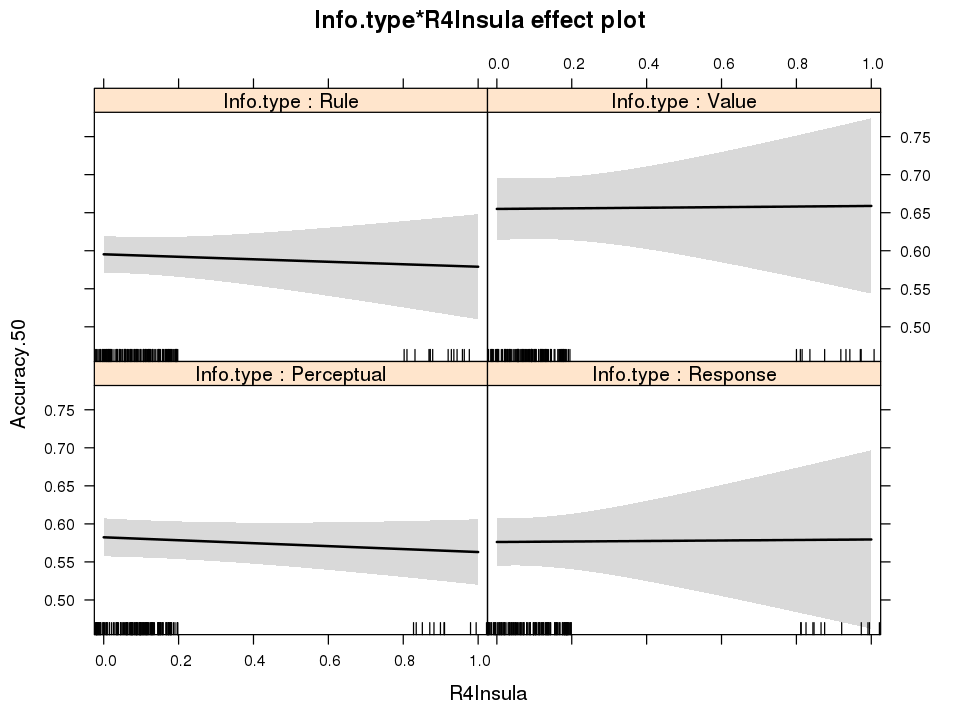

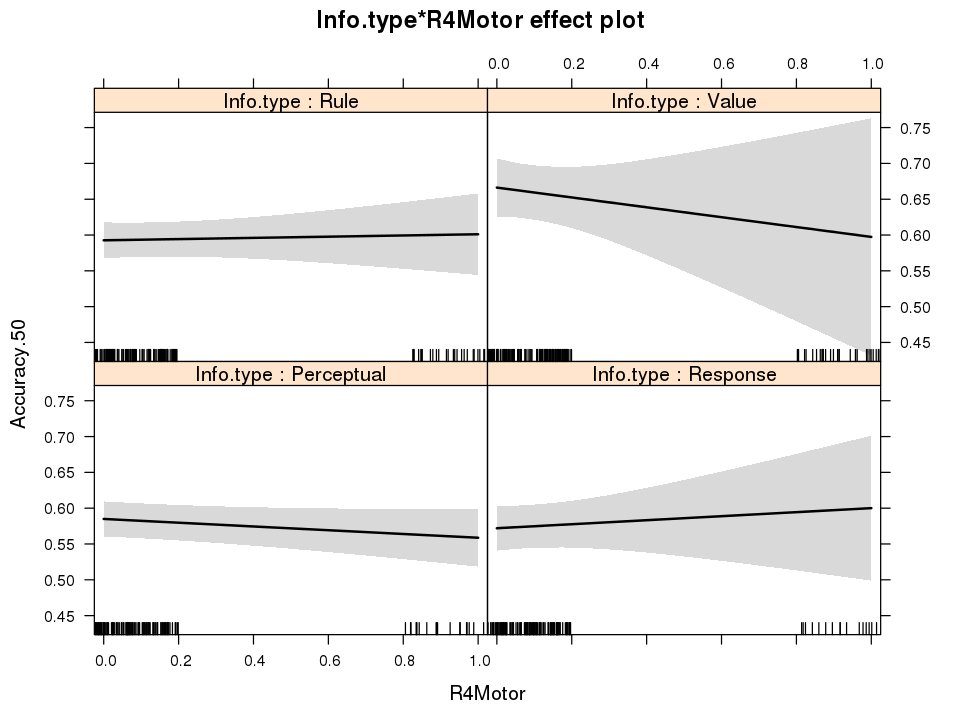

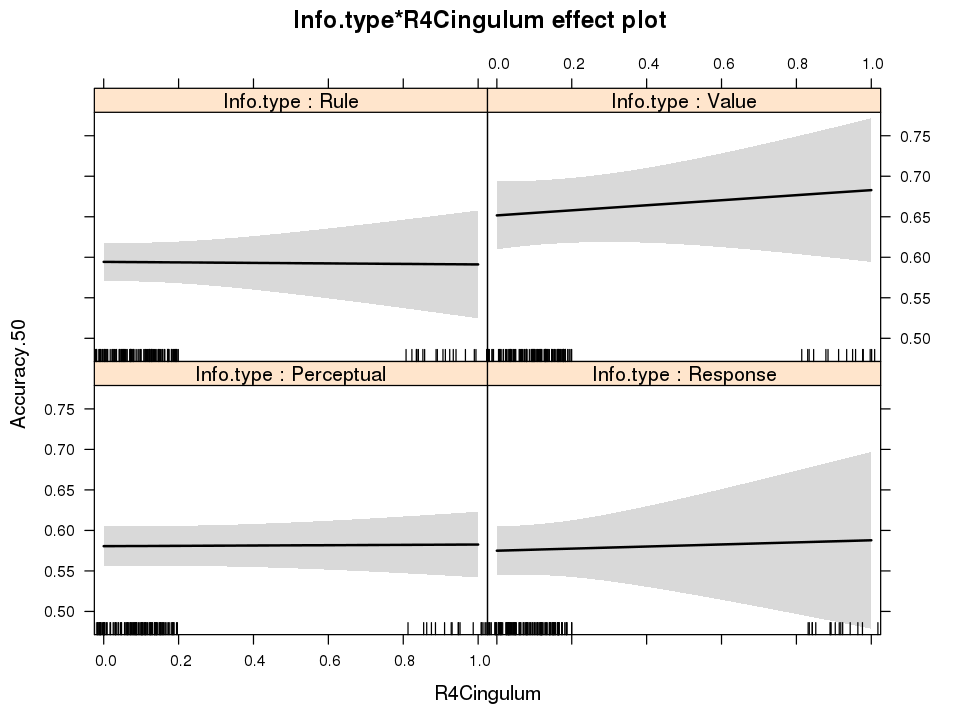

In [196]:
options(repr.plot.width=8, repr.plot.height=6)
fits<-c()
se<-c()
i=1
for (name in R4names){
    ef<-effect(paste('Info.type:',name,sep=''),region_model_reduced_I)
    print(plot(ef))
    #fits[i]<-tail(ef$fit, n=1)
    #se[i]<-tail(ef$se, n=1)
    #i=i+1

    
}
#dd = data.table(name=R4names,se=se,Accuracy=fits)
#ggplot(aes(y = Accuracy, x = name,ymax = Accuracy + se, ymin=Accuracy - se), data = dd)+geom_point()+geom_errorbar()+theme(axis.text.x = element_text(angle = 45, hjust = 1))+ggtitle('Full Model')